In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging
import math
import os
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from polartoolkit import utils as polar_utils

import synthetic_bathymetry_inversion.plotting as synth_plotting
from synthetic_bathymetry_inversion import ice_shelf_stats, synthetic

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import utils

In [2]:
# set grid parameters
spacing = 2e3
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)

plot_region = inversion_region  # vd.pad_region(inversion_region, -3*spacing)

true_density_contrast = 1476

bathymetry, _, _ = synthetic.load_synthetic_model(
    spacing=spacing,
    inversion_region=inversion_region,
    buffer=spacing * 10,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
    plot_topography=False,
    plot_gravity=False,
)

buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# clip to inversion region
bathymetry = bathymetry.sel(
    easting=slice(plot_region[0], plot_region[1]),
    northing=slice(plot_region[2], plot_region[3]),
)

INFO:polartoolkit:converting to be reference to the WGS84 ellipsoid
INFO:polartoolkit:spacing larger than original, filtering and resampling
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


  0%|          | 0/7676 [00:00<?, ?it/s]

In [3]:
# get list of all Antarctic ice shelves
ice_shelves = ice_shelf_stats.get_ice_shelves()

print(f"Number of ice shelves: {len(ice_shelves)}")

# ice_shelves = ice_shelves[ice_shelves.area_km >= 100]

# print(f"Number of ice shelves with area > 100 km^2: {len(ice_shelves)}")

ice_shelves

INFO:synthetic_bathymetry_inversion:Number of unmerged ice shelves: 180
INFO:synthetic_bathymetry_inversion:Combining 2 Ronne_Filchner sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 7 Abbot sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 5 Wordie sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 3 Getz sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Rydberg sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Ross sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 Walgreen sub-shelves
INFO:synthetic_bathymetry_inversion:Combining 2 LarsenD sub-shelves
INFO:synthetic_bathymetry_inversion:Number of removed sub-shelves: 25
INFO:synthetic_bathymetry_inversion:Number of merged ice shelves: 164


Number of ice shelves: 164


,NAME,Regions,TYPE,geometry,area_km
0,Ross,West,FL,"POLYGON ((-240677.184 -678259.006, -240038.274...",480428.37
1,Ronne_Filchner,West,FL,"POLYGON ((-1006734.891 880592.98, -1006335.923...",427041.70
2,Amery,East,FL,"POLYGON ((2134701.422 618463.117, 2131452.011 ...",60797.28
3,LarsenC,Peninsula,FL,"POLYGON ((-2235724.269 1271352.188, -2235828.5...",47443.51
4,Riiser-Larsen,East,FL,"POLYGON ((-592166.317 1592824.258, -593783.16 ...",42913.14
...,...,...,...,...,...
159,Perkins,West,FL,"POLYGON ((-1129608.753 -1201300.734, -1130034....",7.01
160,Paternostro,East,FL,"POLYGON ((824294.485 -2115301.607, 823916.673 ...",6.55
161,Arneb,East,FL,"POLYGON ((333867.825 -1897953.452, 333673.461 ...",6.41
162,Falkner,East,FL,"POLYGON ((425350.532 -1726631.609, 423726.753 ...",5.69


In [4]:
# get gravity and constraint spacing stats on ice shelves
ice_shelf_stats_gdf = pd.read_csv(
    "../results/ice_shelves/ice_shelf_gravity_stats.csv", index_col=None
)
# ice_shelf_stats_gdf = ice_shelf_stats_gdf[ice_shelf_stats_gdf.area_km > 100]
ice_shelf_stats_gdf

,NAME,Regions,TYPE,geometry,area_km,median_constraint_distance,mean_constraint_distance,max_constraint_distance,constraint_proximity_skewness,gravity_disturbance_rms,...,reg_rms,reg_stdev,res_rms,res_stdev,error_rms,error_stdev,residual_constraint_proximity_ratio_rms,residual_constraint_proximity_ratio_stdev,regional_constraint_proximity_ratio_rms,regional_constraint_proximity_ratio_stdev
0,Ross,West,FL,POLYGON ((-240677.18377991652 -678259.00593521...,480428.37,17.282824,17.636882,62.339089,0.431810,44.934094,...,17.851020,17.380028,5.932582,5.931834,12.748633,3.154937,129.988110,129.983190,306.318730,291.707559
1,Ronne_Filchner,West,FL,POLYGON ((-1006734.8906412432 880592.979674786...,427041.70,7.686515,8.739788,46.338298,1.456174,41.514238,...,34.019412,20.803884,3.958367,3.955927,7.952294,1.760702,59.403593,59.405243,350.428117,251.256955
2,Amery,East,FL,POLYGON ((2134701.4219642165 618463.1172190169...,60797.28,16.941666,21.373582,74.852666,0.844014,54.656450,...,40.967810,25.416420,14.932758,12.592517,8.432001,0.497149,504.180788,443.561742,1176.362259,869.215104
3,LarsenC,Peninsula,FL,POLYGON ((-2235724.269360441 1271352.187501361...,47443.51,9.067471,10.260593,36.855613,0.763313,14.824574,...,38.552686,14.808293,5.083237,5.084219,5.735885,1.390208,69.270786,69.137847,509.713990,330.660555
4,Riiser-Larsen,East,FL,POLYGON ((-592166.3173854565 1592824.257663729...,42913.14,17.664812,20.596557,63.202992,0.713248,53.556828,...,81.143217,41.570157,12.794650,12.025394,8.285409,0.728764,448.277737,435.945629,2026.638735,1361.039287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Drury,East,FL,"POLYGON ((895410.318218497 -2105991.070752478,...",55.61,3.143890,3.746163,9.463699,0.496175,85.931453,...,65.638189,0.404523,3.380092,3.648856,12.959736,0.030865,25.727613,26.699924,391.494092,192.394950
123,Zelee,East,FL,POLYGON ((1595256.149328336 -1990608.354406229...,40.65,2.835378,2.856841,6.070070,0.102221,56.605168,...,47.884443,17.421925,5.840224,3.653810,6.485042,1.849987,24.465782,20.543170,109.899298,59.122902
124,Dalk,East,FL,POLYGON ((2199011.8758713417 527659.2832139434...,35.44,1.102750,1.103613,2.569476,0.153243,9.456864,...,9.471496,4.549504,1.696235,1.696235,8.295042,0.233987,2.681972,2.681972,6.377484,5.936761
125,Marret,East,FL,POLYGON ((1739518.675443965 -1925310.880398920...,26.08,1.629186,1.762193,4.782843,0.875108,67.773671,...,35.269017,3.507923,2.258032,2.983219,14.314831,0.472625,4.721960,5.635562,64.876020,33.804194


In [5]:
ice_shelves[~ice_shelves.NAME.isin(ice_shelf_stats_gdf.NAME.values)]

,NAME,Regions,TYPE,geometry,area_km
121,Porter,East,FL,"POLYGON ((1923369.163 1643820.73, 1919731.588 ...",59.28
124,Alison,West,FL,"MULTIPOLYGON (((-1754722.344 256629.32, -17545...",47.71
126,Skallen,East,FL,"POLYGON ((1419424.627 1719449.989, 1419424.898...",35.88
128,Garfield,West,FL,"POLYGON ((-1126042.82 -1198382.673, -1125896.4...",29.68
129,Hummer_Point,Islands,FL,"POLYGON ((-1597171.359 -586925.122, -1597492.7...",28.98
130,Commandant_Charcot,East,FL,"POLYGON ((1784381.94 -1889283.331, 1784550.691...",28.03
131,Suter,East,FL,"POLYGON ((402740.271 -1761647.367, 401424.977 ...",27.39
132,Gannutz,East,FL,"POLYGON ((659406.442 -2053971.977, 659170.776 ...",26.81
133,Harmon_Bay,Islands,FL,"POLYGON ((-1608752.832 -608817.726, -1607549.1...",26.66
134,Fox_East,East,FL,"POLYGON ((2380546.965 -1082661.546, 2380655.74...",26.48


# Ensemble 1: Constraint spacing vs. regional strength

In [6]:
ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_01_constraint_spacing_vs_regional_strength_with_density_estimation"

ensemble_fname = f"{ensemble_path}.csv"

sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df

,constraint_numbers,regional_strengths,constraint_points_fname,constraints_per_10000sq_km,constraints_starting_rmse,starting_bathymetry_fname,starting_prisms_fname,starting_bathymetry_mae,starting_bathymetry_rmse,grav_df_fname,...,true_density_inversion_rmse,true_density_topo_improvement_rmse,final_inverted_bathymetry_fname,final_inversion_results_fname,final_inversion_constraints_rmse,final_inversion_rmse,final_inversion_topo_improvement_rmse,maximum_constraint_proximity,constraint_proximity_skewness,median_proximity
0,4,20.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,26.666656,19.654786,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.416304,25.705860,20.615582,51.305,0.483691,17.755
1,4,40.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,54.946683,-8.625241,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,1.817794,47.161472,-0.840030,51.305,0.483691,17.755
2,4,60.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,83.417783,-37.096341,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,2.235913,64.446391,-18.124949,51.305,0.483691,17.755
3,4,80.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,111.988379,-65.666937,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,2.521366,73.064049,-26.742607,51.305,0.483691,17.755
4,4,100.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,282.666667,0.003561,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,28.351052,46.321442,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,140.641935,-94.320493,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,2.673602,76.397586,-30.076144,51.305,0.483691,17.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,650,120.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,496.666667,0.283029,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,3.335341,5.928078,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,2.052972,3.875105,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,0.797255,3.143586,2.784492,6.333,-0.144477,2.520
96,650,140.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,496.666667,0.283029,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,3.335341,5.928078,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,2.055300,3.872778,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,0.820418,3.222559,2.705518,6.333,-0.144477,2.520
97,650,160.0,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,496.666667,0.283029,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,3.335341,5.928078,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,...,2.088355,3.839723,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,../results/Ross_Sea/ensembles/Ross_Sea_ensembl...,0.834046,3.239747,2.688331,6.333,-0.1

In [7]:
sampled_params_df[
    [
        "starting_bathymetry_rmse",
        "true_density_inversion_rmse",
        "true_density_topo_improvement_rmse",
        "final_inversion_rmse",
        "final_inversion_topo_improvement_rmse",
    ]
].describe()

,starting_bathymetry_rmse,true_density_inversion_rmse,true_density_topo_improvement_rmse,final_inversion_rmse,final_inversion_topo_improvement_rmse
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,26.063273,38.599665,-12.536393,20.954113,5.109160
std,14.282003,61.254465,52.420555,26.769199,18.506826
min,5.928078,2.052972,-238.706954,2.422678,-74.883909
25%,11.358149,3.476150,-4.074898,4.083646,3.423450
50%,24.798911,9.146388,5.988084,8.180896,9.107970
75%,41.525870,42.535287,12.998504,25.834346,15.326811
max,46.321442,285.028396,31.052620,121.205351,31.573318


In [12]:
sampled_params_df.describe()

,constraint_numbers,regional_strengths,constraints_per_10000sq_km,constraints_starting_rmse,starting_bathymetry_mae,starting_bathymetry_rmse,regional_stdev,regional_error,gravity_anomaly_rms,best_density_contrast,...,density_estimation_inversion_rmse,density_estimation_topo_improvement_rmse,true_density_inversion_rmse,true_density_topo_improvement_rmse,final_inversion_constraints_rmse,final_inversion_rmse,final_inversion_topo_improvement_rmse,maximum_constraint_proximity,constraint_proximity_skewness,median_proximity
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,149.900000,110.000000,330.933333,0.083960,15.135698,26.063273,22.503720,2.175436,40.200314,2571.620000,...,301.971157,-275.907884,38.599665,-12.536393,1.353637,20.954113,5.109160,25.135300,0.259203,8.919700
std,200.751844,57.735027,66.431876,0.095932,8.923906,14.282003,11.811390,3.532693,6.321093,705.793211,...,120.556429,121.334630,61.254465,52.420555,0.677834,26.769199,18.506826,14.650223,0.192085,5.092535
min,4.000000,20.000000,282.666667,0.003561,3.335341,5.928078,4.091585,0.070938,32.531647,1508.000000,...,72.116315,-443.088677,2.052972,-238.706954,0.317716,2.422678,-74.883909,6.333000,-0.144477,2.520000
25%,12.000000,60.000000,285.333333,0.006497,6.381548,11.358149,12.274756,0.153843,34.332353,1845.000000,...,209.102186,-375.882388,3.476150,-4.074898,0.942926,4.083646,3.423450,12.387000,0.146099,4.256000
50%,53.000000,110.000000,299.000000,0.045115,13.749814,24.798911,22.503720,0.488406,38.992531,2731.500000,...,335.209546,-306.034425,9.146388,5.988084,1.113402,8.180896,9.107970,20.771500,0.277189,7.956500
75%,210.000000,160.000000,350.000000,0.131169,24.695174,41.525870,32.732684,2.360761,45.448628,3300.000000,...,402.580836,-185.831308,42.535287,12.998504,1.570118,25.834346,15.326811,38.792000,0.441687,13.483000
max,650.000000,200.000000,496.666667,0.283029,28.351052,46.321442,40.915854,16.353607,51.523481,3300.000000,...,449.027895,-26.020559,285.028396,31.052620,3.725163,121.205351,31.573318,51.305000,0.483691,17.755000


## Predict ice shelves inversion error and topo improvement

In [15]:
ds = sampled_params_df.set_index(["median_proximity", "regional_stdev"]).to_xarray()

for p in ["reg_stdev", "topo_free_disturbance_stdev"]:
    for i, row in ice_shelf_stats_gdf.iterrows():
        inversion_rmse = ds.final_inversion_rmse.sel(
            median_proximity=row.median_constraint_distance,
            regional_stdev=row[p],
            method="nearest",
        ).values
        topo_improvement_rmse = ds.final_inversion_topo_improvement_rmse.sel(
            median_proximity=row.median_constraint_distance,
            regional_stdev=row[p],
            method="nearest",
        ).values
        ice_shelf_stats_gdf.loc[i, f"inversion_rmse_from_{p}"] = inversion_rmse
        ice_shelf_stats_gdf.loc[i, f"topo_improvement_rmse_from_{p}"] = (
            topo_improvement_rmse
        )

ice_shelf_stats_gdf

,NAME,Regions,TYPE,geometry,area_km,median_constraint_distance,mean_constraint_distance,max_constraint_distance,constraint_proximity_skewness,gravity_disturbance_rms,...,error_rms,error_stdev,residual_constraint_proximity_ratio_rms,residual_constraint_proximity_ratio_stdev,regional_constraint_proximity_ratio_rms,regional_constraint_proximity_ratio_stdev,inversion_rmse_from_reg_stdev,topo_improvement_rmse_from_reg_stdev,inversion_rmse_from_topo_free_disturbance_stdev,topo_improvement_rmse_from_topo_free_disturbance_stdev
0,Ross,West,FL,POLYGON ((-240677.18377991652 -678259.00593521...,480428.37,17.282824,17.636882,62.339089,0.431810,44.934094,...,12.748633,3.154937,129.988110,129.983190,306.318730,291.707559,73.064049,-26.742607,73.064049,-26.742607
1,Ronne_Filchner,West,FL,POLYGON ((-1006734.8906412432 880592.979674786...,427041.70,7.686515,8.739788,46.338298,1.456174,41.514238,...,7.952294,1.760702,59.403593,59.405243,350.428117,251.256955,6.699684,15.048539,6.699684,15.048539
2,Amery,East,FL,POLYGON ((2134701.4219642165 618463.1172190169...,60797.28,16.941666,21.373582,74.852666,0.844014,54.656450,...,8.432001,0.497149,504.180788,443.561742,1176.362259,869.215104,80.184166,-33.862724,83.511614,-37.190171
3,LarsenC,Peninsula,FL,POLYGON ((-2235724.269360441 1271352.187501361...,47443.51,9.067471,10.260593,36.855613,0.763313,14.824574,...,5.735885,1.390208,69.270786,69.137847,509.713990,330.660555,8.258980,19.590620,8.258980,19.590620
4,Riiser-Larsen,East,FL,POLYGON ((-592166.3173854565 1592824.257663729...,42913.14,17.664812,20.596557,63.202992,0.713248,53.556828,...,8.285409,0.728764,448.277737,435.945629,2026.638735,1361.039287,121.205351,-74.883909,121.205351,-74.883909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Drury,East,FL,"POLYGON ((895410.318218497 -2105991.070752478,...",55.61,3.143890,3.746163,9.463699,0.496175,85.931453,...,12.959736,0.030865,25.727613,26.699924,391.494092,192.394950,3.039734,5.619305,3.039734,5.619305
123,Zelee,East,FL,POLYGON ((1595256.149328336 -1990608.354406229...,40.65,2.835378,2.856841,6.070070,0.102221,56.605168,...,6.485042,1.849987,24.465782,20.543170,109.899298,59.122902,2.561081,3.366997,2.433807,3.494270
124,Dalk,East,FL,POLYGON ((2199011.8758713417 527659.2832139434...,35.44,1.102750,1.103613,2.569476,0.153243,9.456864,...,8.295042,0.233987,2.681972,2.681972,6.377484,5.936761,2.485810,3.442267,2.422678,3.505400
125,Marret,East,FL,POLYGON ((1739518.675443965 -1925310.880398920...,26.08,1.629186,1.762193,4.782843,0.875108,67.773671,...,14.314831,0.472625,4.721960,5.635562,64.876020,33.804194,2.485810,3.442267,2.422678,3.505400


In [16]:
# predict_on = "partial_topo_free_disturbance_stdev"
predict_on = "topo_free_disturbance_stdev"
# predict_on = "reg_stdev"

In [17]:
# show limits of the parameter space for Ensemble 1
print(
    "Constraint proximity limits: ",
    f"{sampled_params_df.median_proximity.min()}, ",
    sampled_params_df.median_proximity.max(),
)
print(
    "Regional strength limits ",
    f"{sampled_params_df.regional_stdev.min()}, ",
    sampled_params_df.regional_stdev.max(),
)

Constraint proximity limits:  2.52,  17.755
Regional strength limits  4.091585441128275,  40.91585441128274


In [18]:
# # predict inversion_mae
# ice_shelf_stats_gdf = synthetic.verde_predict_trend(
#     data_to_fit=sampled_params_df,
#     cols_to_fit=["median_proximity", "regional_stdev", "inversion_mae"],
#     data_to_predict=ice_shelf_stats_gdf,
#     cols_to_predict=["median_constraint_distance", predict_on, "inversion_mae"],
#     degree=6,
# )
# # predict topo_improvement_mae
# ice_shelf_stats_gdf = synthetic.verde_predict_trend(
#     data_to_fit=sampled_params_df,
#     cols_to_fit=["median_proximity", "regional_stdev", "topo_improvement_mae"],
#     data_to_predict=ice_shelf_stats_gdf,
#     cols_to_predict=["median_constraint_distance", predict_on, "topo_improvement_mae"],
#     degree=4,
# )

shelves_in_limits = ice_shelf_stats_gdf.copy()

# exclude shelves outsite param limits of Ensemble 1
# round lims to ints to include shelves on the edge
shelves_in_limits = shelves_in_limits[
    shelves_in_limits.median_constraint_distance.between(
        math.floor(sampled_params_df.median_proximity.min()) - 1,
        math.ceil(sampled_params_df.median_proximity.max()) + 1,
    )
    & shelves_in_limits[predict_on].between(
        math.floor(sampled_params_df.regional_stdev.min()) - 1,
        math.ceil(sampled_params_df.regional_stdev.max()) + 1,
    )
]


# plot only the largest shelves which fall in the ensemble limits
shelves_to_plot = shelves_in_limits[shelves_in_limits.area_km > 1000]
# shelves_to_plot = shelves_to_plot[shelves_to_plot.NAME.isin(ice_shelves.iloc[0:50].NAME)]

shelves_to_plot[
    [
        "NAME",
        f"inversion_rmse_from_{predict_on}",
        f"topo_improvement_rmse_from_{predict_on}",
    ]
]

,NAME,inversion_rmse_from_topo_free_disturbance_stdev,topo_improvement_rmse_from_topo_free_disturbance_stdev
0,Ross,73.064049,-26.742607
1,Ronne_Filchner,6.699684,15.048539
2,Amery,83.511614,-37.190171
3,LarsenC,8.258980,19.590620
4,Riiser-Larsen,121.205351,-74.883909
5,Fimbul,6.699755,12.412115
6,Brunt_Stancomb,42.071779,-0.545908
7,Getz,11.485300,23.274995
9,Abbot,10.136220,17.713380
11,George_VI,6.699684,15.048539


In [24]:
# print shelves which are not in the ensemble limits
ice_shelf_stats_gdf[~ice_shelf_stats_gdf.NAME.isin(shelves_to_plot.NAME)][
    ["NAME", "median_constraint_distance", "topo_free_disturbance_stdev"]
]

,NAME,median_constraint_distance,topo_free_disturbance_stdev
8,Baudouin,22.523870,36.100308
10,Shackleton,26.857001,25.025766
17,Jelbart,11.208331,60.214682
21,Ekstrom,2.733504,66.049467
28,Prince_Harald,25.980222,23.053617
...,...,...,...
122,Drury,3.143890,3.244333
123,Zelee,2.835378,13.862096
124,Dalk,1.102750,6.245739
125,Marret,1.629186,6.491142


In [25]:
df = shelves_to_plot[
    [
        "NAME",
        f"topo_improvement_rmse_from_{predict_on}",
    ]
]
df.sort_values(f"topo_improvement_rmse_from_{predict_on}")

,NAME,topo_improvement_rmse_from_topo_free_disturbance_stdev
4,Riiser-Larsen,-74.883909
2,Amery,-37.190171
0,Ross,-26.742607
15,Wilkins,-26.742607
31,Cook,-2.234796
6,Brunt_Stancomb,-0.545908
29,Thwaites,3.494270
44,Nansen,4.300839
13,Borchgrevink,7.371521
27,Mertz,7.432474


In [26]:
print(len(shelves_to_plot))
print(
    len(
        shelves_to_plot[shelves_to_plot[f"topo_improvement_rmse_from_{predict_on}"] > 0]
    )
)
perc_improvement = (
    len(
        shelves_to_plot[shelves_to_plot[f"topo_improvement_rmse_from_{predict_on}"] > 0]
    )
    / len(shelves_to_plot)
    * 100
)
print(
    f"{round(perc_improvement, 1)}% of 50 largest ice shelves predicted to have improved topography"
)

43
37
86.0% of 50 largest ice shelves predicted to have improved topography


In [27]:
print(len(shelves_in_limits))
print(
    len(
        shelves_in_limits[
            shelves_in_limits[f"topo_improvement_rmse_from_{predict_on}"] > 0
        ]
    )
)
perc_improvement = (
    len(
        shelves_in_limits[
            shelves_in_limits[f"topo_improvement_rmse_from_{predict_on}"] > 0
        ]
    )
    / len(shelves_in_limits)
    * 100
)
print(
    f"{round(perc_improvement, 1)}% of ice shelves predicted to have improved topography"
)

112
105
93.8% of ice shelves predicted to have improved topography


In [86]:
df = shelves_to_plot[
    [
        "NAME",
        f"inversion_rmse_from_{predict_on}",
    ]
]
df.sort_values(f"inversion_rmse_from_{predict_on}")

,NAME,inversion_rmse_from_topo_free_disturbance_stdev
29,Thwaites,2.433807
24,Pine_Island,3.068883
41,Quar,3.462669
40,LarsenB,3.683631
27,Mertz,3.925676
38,Holmes,3.998985
30,Bach,3.998985
47,Publications,4.089869
44,Nansen,4.358200
34,Venable,4.482789


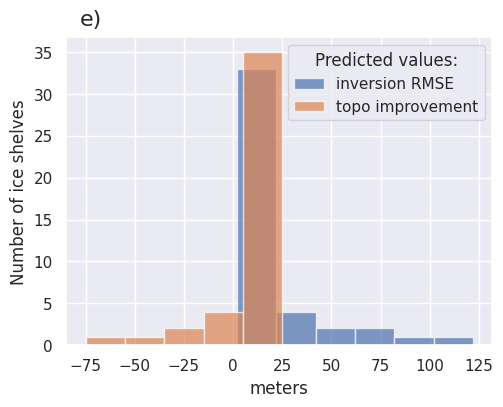

In [28]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(5.5, 4))
ax.hist(
    shelves_to_plot[f"inversion_rmse_from_{predict_on}"],
    # bins=8,
    bins=range(
        round(min(shelves_to_plot[f"inversion_rmse_from_{predict_on}"])),
        round(max(shelves_to_plot[f"inversion_rmse_from_{predict_on}"])) + 20,
        20,
    ),
    alpha=0.7,
    label="inversion RMSE",
)
ax.hist(
    shelves_to_plot[f"topo_improvement_rmse_from_{predict_on}"],
    # bins=8,
    bins=range(
        round(min(shelves_to_plot[f"topo_improvement_rmse_from_{predict_on}"])),
        round(max(shelves_to_plot[f"topo_improvement_rmse_from_{predict_on}"])) + 20,
        20,
    ),
    alpha=0.7,
    label="topo improvement",
)
fig.text(0.15, 0.95, "e)", fontsize=16, va="top", ha="left")

# ax.set_xticks(np.arange(-250, 300, 50))
# ax.tick_params(axis='both', colors='black', size=5, width=1)
# plt.tick_params(which='both', axis="both", width=20)

plt.xlabel("meters")
plt.ylabel("Number of ice shelves")
plt.legend(title="Predicted values:")

fig.savefig(
    "../paper/figures/predicted_ice_shelf_values.png",
    bbox_inches="tight",
    dpi=300,
)

In [80]:
sampled_params_df[
    [
        "constraint_numbers",
        "constraints_per_10000sq_km",
        "median_proximity",
        "regional_stdev",
    ]
]

,constraint_numbers,constraints_per_10000sq_km,median_proximity,regional_stdev
0,4,282.666667,17.755,4.091585
1,4,282.666667,17.755,8.183171
2,4,282.666667,17.755,12.274756
3,4,282.666667,17.755,16.366342
4,4,282.666667,17.755,20.457927
...,...,...,...,...
95,650,496.666667,2.520,24.549513
96,650,496.666667,2.520,28.641098
97,650,496.666667,2.520,32.732684
98,650,496.666667,2.520,36.824269


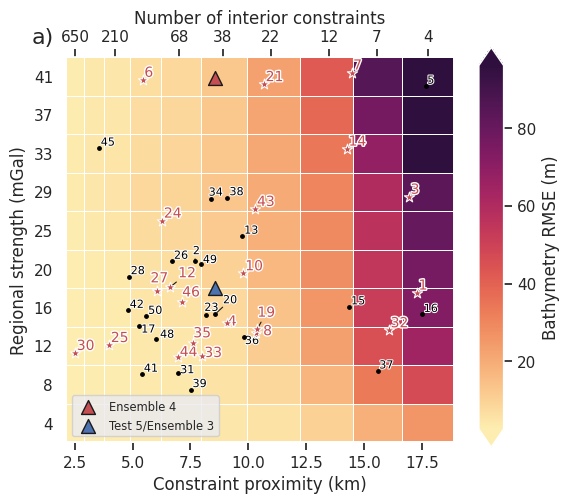

In [82]:
fig = synth_plotting.plot_2var_ensemble(
    sampled_params_df,
    figsize=(5, 5),
    x="median_proximity",
    x_title="Constraint proximity (km)",
    # x="constraint_numbers",
    # x_title="Number of constraints",
    # x="constraints_per_10000sq_km",
    # x_title="Constraints per 10000 $km^2$",
    y="regional_stdev",
    y_title="Regional strength (mGal)",
    background="final_inversion_rmse",
    background_title="Bathymetry RMSE (m)",
    background_robust=True,
    background_cpt_lims=polar_utils.get_min_max(
        sampled_params_df.final_inversion_rmse,
        robust=True,
        # robust_percentiles=(0.05, 0.85),
    ),
    # logx=True,
    # flipx=True,
    constrained_layout=False,
)
ax = fig.get_axes()[0]
plt.gcf().text(0.1, 0.9, "a)", fontsize=16, va="bottom", ha="right")
ax.grid(True)

# add second x axis with number of constraints
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
x_tick_vals = sampled_params_df.median_proximity.unique()
x_tick_labels = sampled_params_df.constraint_numbers.unique()
inds_to_remove = [-2, -4]
x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
x_tick_labels = [round(x) for x in x_tick_labels]
ax2.set_xticks(x_tick_vals)
ax2.set_xticklabels(x_tick_labels)
ax2.grid(False)
ax2.set_xlabel("Number of interior constraints")

# specify y ticks
yvals = list(sampled_params_df.regional_stdev.unique())
ax.set_yticks(yvals)
ax.set_yticklabels([round(x) for x in yvals])

# df = shelves_to_plot.sort_values(
#     f"topo_improvement_mae_from_{predict_on}", ascending=False
# )
df = shelves_to_plot
# df = shelves_to_plot.sort_values(f"inversion_mae_from_{predict_on}", ascending=True)
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y=predict_on,
    ice_shelves=df,
    # shelves_to_label=df[df.NAME.isin(ice_shelves.iloc[0:50].NAME)].NAME.unique(),
    ax=ax,
    legend=False,
    # col_to_add_to_label=f"topo_improvement_mae_from_{predict_on}",
    # col_to_add_to_label=f"inversion_mae_from_{predict_on}",
)
ax.scatter(
    x=8.557,  # median constraint proximity
    y=40.8,  # regional stdev
    marker="^",
    s=100,
    color="r",
    linewidth=1,
    edgecolor="k",
    label="Ensemble 4",
)
ax.scatter(
    x=8.557,  # median constraint proximity
    y=18.41093,  # regional stdev
    marker="^",
    s=100,
    color="b",
    linewidth=1,
    edgecolor="k",
    label="Test 5/Ensemble 3",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[-2:],
    labels[-2:],
    fontsize="x-small",
    loc="lower left",
    # labelspacing=0.2,
    # handletextpad=0.2,
    # borderpad=0.2,
    # borderaxespad=0.1,
)

plt.minorticks_off()

fig.savefig(
    "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_bathy_error_2var.png",
    bbox_inches="tight",
    dpi=300,
)

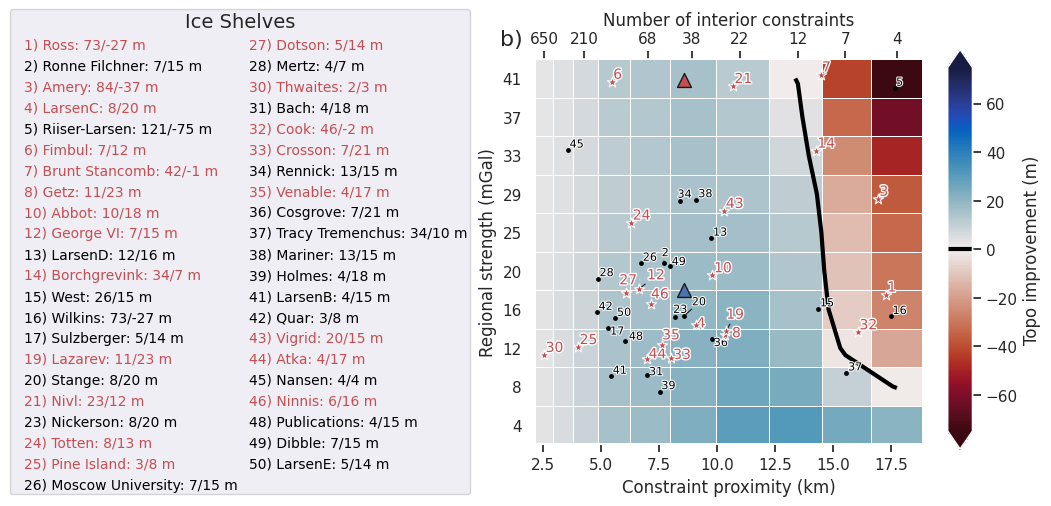

In [ ]:
df = sampled_params_df
fig = synth_plotting.plot_2var_ensemble(
    df,
    figsize=(5, 5),
    x="median_proximity",
    x_title="Constraint proximity (km)",
    # x="constraint_numbers",
    # x_title="Number of constraints",
    # x="constraints_per_10000sq_km",
    # x_title="Constraints per 10000 $km^2$",
    y="regional_stdev",
    y_title="Regional strength (mGal)",
    background="final_inversion_topo_improvement_rmse",
    background_title="Topo improvement (m)",
    background_cmap="cmo.balance_r",
    background_robust=True,
    background_cpt_lims=polar_utils.get_min_max(
        df.final_inversion_topo_improvement_rmse,
        # robust=True,
        absolute=True,
        robust_percentiles=(0.01, 0.99),
    ),
    plot_contours=[0],
    contour_color="black",
    # logx=True,
    # flipx=True,
    constrained_layout=False,
)
ax = fig.get_axes()[0]
plt.gcf().text(0.1, 0.9, "b)", fontsize=16, va="bottom", ha="right")
ax.grid(True)

# add second x axis just change labels not values
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

x_tick_vals = sampled_params_df.median_proximity.unique()
x_tick_labels = sampled_params_df.constraint_numbers.unique()

inds_to_remove = [-2, -4]
x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
x_tick_labels = np.delete(x_tick_labels, inds_to_remove)

x_tick_labels = [round(x) for x in x_tick_labels]
ax2.set_xticks(x_tick_vals)
ax2.set_xticklabels(x_tick_labels)
ax2.grid(False)
ax2.set_xlabel("Number of interior constraints")

# specify y ticks
yvals = list(sampled_params_df.regional_stdev.unique())
ax.set_yticks(yvals)
ax.set_yticklabels([round(x) for x in yvals])

# df = shelves_to_plot.sort_values(
#     f"topo_improvement_mae_from_{predict_on}", ascending=False
# )
df = shelves_to_plot
# df = shelves_to_plot.sort_values(f"inversion_mae_from_{predict_on}", ascending=True)
ice_shelf_stats.add_shelves_to_ensembles(
    x="median_constraint_distance",
    y=predict_on,
    ice_shelves=df,
    shelves_to_label=df.NAME.unique(),
    ax=ax,
    legend=True,
    legend_cols=2,
    legend_loc="center right",
    legend_bbox_to_anchor=(-0.15, 0.5),
    # col_to_add_to_label=f"topo_improvement_mae_from_{predict_on}",
    # col_to_add_to_label=f"topo_improvement_rmse_from_{predict_on}",
    col_to_add_to_label=[
        f"inversion_rmse_from_{predict_on}",
        f"topo_improvement_rmse_from_{predict_on}",
    ],
)

ax.scatter(
    x=8.557,  # median constraint proximity
    y=40.8,  # regional stdev
    marker="^",
    s=100,
    color="r",
    linewidth=1,
    edgecolor="k",
    # label="Ensemble 4",
)
ax.scatter(
    x=8.557,  # median constraint proximity
    y=18.41093,  # regional stdev
    marker="^",
    s=100,
    color="b",
    linewidth=1,
    edgecolor="k",
    # label="Test 5/Ensemble 3",
)

# ax.yaxis.set_visible(False)
plt.minorticks_off()


fig.savefig(
    "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_topo_improvement_2var.png",
    bbox_inches="tight",
    dpi=300,
)

Text(0.01, 0.95, 'c)')

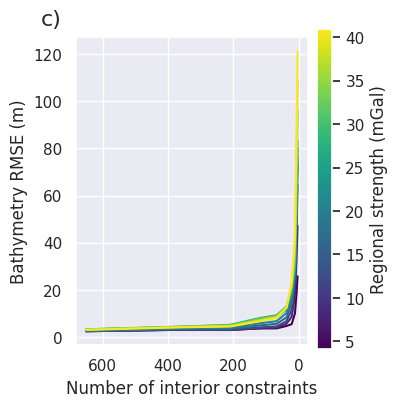

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 4),
    # x="median_proximity",
    # x_label="Constraints proximity (km)",
    # x="constraints_per_10000sq_km",
    # x_label="Constraints per 10000 $km^2$",
    x="constraint_numbers",
    x_label="Number of interior constraints",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="regional_stdev",
    cbar_label="Regional strength (mGal)",
    # logx=True,
    markersize=0,
    flipx=True,
)
ax = fig.get_axes()[0]
plt.gcf().text(0.01, 0.95, "c)", fontsize=16, va="top", ha="left")

In [32]:
x = "constraint_numbers"
y = "median_proximity"

df = sampled_params_df[[x, y]].copy()

df = pd.concat(
    [df, pd.DataFrame({x: np.arange(df[x].min(), df[x].max(), 1)})]
).drop_duplicates(subset=x)
df = df.sort_values(x).reset_index(drop=True)

df = synthetic.scipy_interp1d(
    df,
    to_interp=y,
    interp_on=x,
    method="cubic",
)
df[df[x].isin([30, 46, 48])]

,constraint_numbers,median_proximity
26,30,9.722335
42,46,8.261219
44,48,8.119503


In [33]:
sampled_params_df[["median_proximity", "constraint_numbers"]].drop_duplicates()

,median_proximity,constraint_numbers
0,17.755,4
10,15.534,7
20,13.483,12
30,10.966,22
40,8.902,38
50,7.011,68
60,5.491,119
70,4.256,210
80,3.279,369
90,2.520,650


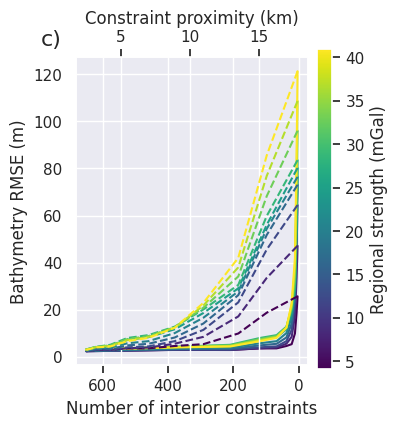

In [ ]:
ax2 = ax.twiny()
groupby_col = "regional_stdev"
results = sampled_params_df
x = "median_proximity"
y = "final_inversion_rmse"

grouped = results.groupby(groupby_col)
norm = plt.Normalize(
    vmin=results[groupby_col].values.min(), vmax=results[groupby_col].values.max()
)
slopes = []
lines = []
for _i, (name, group) in enumerate(grouped):
    ax2.plot(
        group[x],
        group[y],
        "--",
        markersize=0,
        color=plt.cm.viridis(norm(name)),
    )
ax2.set_xlabel("Constraint proximity (km)")

fig.savefig(
    "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_bathy_error_vs_median_proximity.png",
    bbox_inches="tight",
    dpi=300,
)
fig

Text(0.01, 0.95, 'e)')

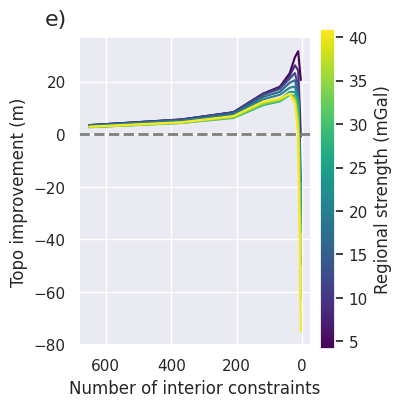

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 4),
    # x="median_proximity",
    # x_label="Constraints distance (km)",
    # x="constraints_per_10000sq_km",
    # x_label="Constraints per 10000 $km^2$",
    x="constraint_numbers",
    x_label="Number of interior constraints",
    y="final_inversion_topo_improvement_rmse",
    y_label="Topo improvement (m)",
    groupby_col="regional_stdev",
    cbar_label="Regional strength (mGal)",
    horizontal_line=0,
    # logx=True,
    # y_lims=(0, 40),
    markersize=0,
    # plot_maximums=True,
    flipx=True,
)
ax = fig.get_axes()[0]
plt.gcf().text(0.01, 0.95, "e)", fontsize=16, va="top", ha="left")

In [ ]:
grouped = sampled_params_df.groupby("regional_stdev")
x = "constraint_numbers"
y = "final_inversion_topo_improvement_rmse"

constraint_numbers_at_max = []
for _i, (_name, group) in enumerate(grouped):
    df = group[[x, y]].copy()

    df = pd.concat(
        [df, pd.DataFrame({x: np.arange(df[x].min(), df[x].max(), 1)})]
    ).drop_duplicates(subset=x)
    df = df.sort_values(x).reset_index(drop=True)

    df = synthetic.scipy_interp1d(
        df,
        to_interp=y,
        interp_on=x,
        method="cubic",
    )
    max_ind = df[y].idxmax()
    constraint_numbers_at_max.append(df[x].iloc[max_ind])
constraint_numbers_at_max

[15, 17, 18, 17, 17, 17, 17, 17, 47, 48]

In [ ]:
grouped = sampled_params_df.groupby("regional_stdev")
x = "median_proximity"
y = "final_inversion_topo_improvement_rmse"

median_proximity_at_max = []
for _i, (_name, group) in enumerate(grouped):
    df = group[[x, y]].copy()

    df = pd.concat(
        [df, pd.DataFrame({x: np.arange(df[x].min(), df[x].max(), 1)})]
    ).drop_duplicates(subset=x)
    df = df.sort_values(x).reset_index(drop=True)

    df = synthetic.scipy_interp1d(
        df,
        to_interp=y,
        interp_on=x,
        method="cubic",
    )
    max_ind = df[y].idxmax()
    median_proximity_at_max.append(df[x].iloc[max_ind])
median_proximity_at_max

[12.52, 12.52, 11.52, 11.52, 11.52, 11.52, 12.52, 8.902, 8.902, 8.902]

In [38]:
df = sampled_params_df[["median_proximity", "constraint_numbers"]].drop_duplicates()
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {
                "constraint_numbers": np.arange(
                    df.constraint_numbers.min(), df.constraint_numbers.max(), 1
                )
            }
        ),
    ]
).drop_duplicates(subset="constraint_numbers")
df = df.sort_values("constraint_numbers").reset_index(drop=True)

df = synthetic.scipy_interp1d(
    df,
    to_interp="median_proximity",
    interp_on="constraint_numbers",
    method="cubic",
)
df[df.constraint_numbers.isin(constraint_numbers_at_max)]

,median_proximity,constraint_numbers
11,12.603298,15
13,12.077271,17
14,11.831991,18
43,8.189504,47
44,8.119503,48


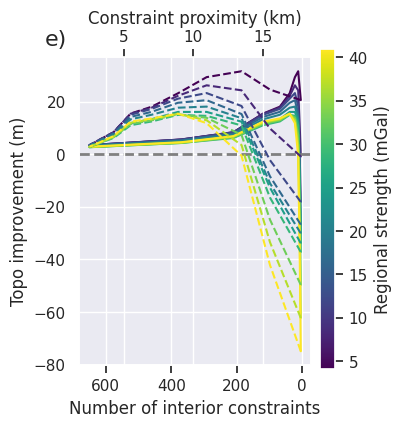

In [ ]:
ax2 = ax.twiny()
groupby_col = "regional_stdev"
results = sampled_params_df
x = "median_proximity"
y = "final_inversion_topo_improvement_rmse"

grouped = results.groupby(groupby_col)

norm = plt.Normalize(
    vmin=results[groupby_col].values.min(), vmax=results[groupby_col].values.max()
)
slopes = []
lines = []
for _i, (name, group) in enumerate(grouped):
    ax2.plot(
        group[x],
        group[y],
        "--",
        markersize=0,
        color=plt.cm.viridis(norm(name)),
    )
    # df = group[[x, y]].copy()

    # df = pd.concat([
    #     df,
    #     pd.DataFrame({x: np.arange(df[x].min(), df[x].max(), 1)})]
    # ).drop_duplicates(subset=x)
    # df = df.sort_values(x).reset_index(drop=True)

    # df = synthetic.scipy_interp1d(
    #     df,
    #     to_interp=y,
    #     interp_on=x,
    #     method="cubic",
    # )

    # max_ind = df[y].idxmax()
    # ax2.scatter(
    #     x=df[x].iloc[max_ind],
    #     y=df[y].iloc[max_ind],
    #     marker="*",
    #     edgecolor="black",
    #     linewidth=0.5,
    #     color=plt.cm.viridis(norm(name)),
    #     s=60,
    #     zorder=20,
    # )
    # print(f"Max {y} at {x}: {df[x].iloc[max_ind]}")

# ax2.invert_xaxis()
ax2.set_xlabel("Constraint proximity (km)")
# fig.savefig(
#     "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_topo_improvement_vs_median_proximity.png",
#     bbox_inches="tight",
#     dpi=300,
# )
fig

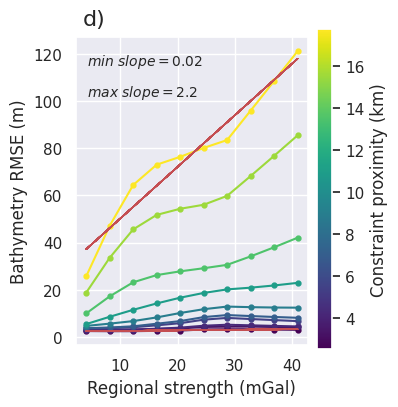

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 4),
    x="regional_stdev",
    x_label="Regional strength (mGal)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="median_proximity",
    cbar_label="Constraint proximity (km)",
    # groupby_col="constraint_numbers",
    # cbar_label="Number of constraints",
    # groupby_col="constraints_per_10000sq_km",
    # cbar_label="Constraints per 10000 $km^2$",
    trend_line=True,
    slope_min_max=True,
    # slope_mean=True,
    slope_decimals=2,
)

plt.gcf().text(0.15, 0.95, "d)", fontsize=16, va="top", ha="left")

plt.savefig(
    "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_bathy_error_vs_regional_strength.png",
    bbox_inches="tight",
    dpi=300,
)

Text(0.15, 0.95, 'f)')

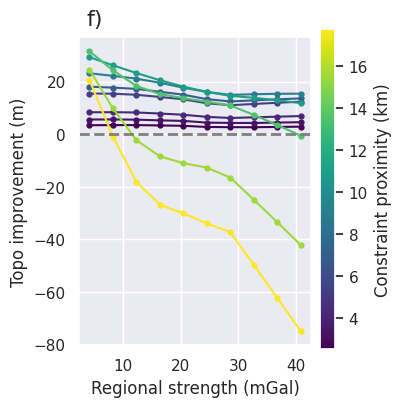

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    figsize=(3, 4),
    x="regional_stdev",
    x_label="Regional strength (mGal)",
    y="final_inversion_topo_improvement_rmse",
    y_label="Topo improvement (m)",
    groupby_col="median_proximity",
    cbar_label="Constraint proximity (km)",
    # groupby_col="constraints_per_10000sq_km",
    # cbar_label="Constraints per 10000 $km^2$",
    horizontal_line=0,
)
plt.gcf().text(0.15, 0.95, "f)", fontsize=16, va="top", ha="left")

# plt.savefig(
#     "../paper/figures/Ross_Sea_constraint_vs_regional_ensemble_topo_improvement_vs_regional_strength.png",
#     bbox_inches="tight",
#     dpi=300,
# )

### Correlation between true regional strength and partial topo-corrected disturbance
* we want to estimate where ice shelves would fall on the above plots
* need to estimate shelve's regional std. and constraint spacing

In [ ]:
# for i, row in sampled_params_df.iterrows():
#     grav_df = pd.read_csv(row.grav_df_fname)

#     sampled_params_df.loc[i, "misfit_stdev"] = grav_df.misfit.std()
#     sampled_params_df.loc[i, "grav_anom_stdev"] = grav_df.gravity_anomaly.std()
#     sampled_params_df.loc[i, "estimated_regional_stdev"] = grav_df.reg.std()
#     sampled_params_df.loc[i, "estimated_residual_stdev"] = grav_df.res.std()
#     sampled_params_df.loc[i, "reg_res_ratio_stdev"] = (grav_df.reg / grav_df.res).std()
#     sampled_params_df.loc[i, "reg_median_proximity_ratio_stdev"] = (
#         grav_df.reg / row.median_proximity
#     ).std()
#     sampled_params_df.loc[i, "reg_constraint_num_ratio_stdev"] = (
#         grav_df.reg / row.constraint_numbers
#     ).std()

# sampled_params_df["estimated_regional_stdev_median_proximity_ratio"] = (
#     sampled_params_df.estimated_regional_stdev
#     / (1 / sampled_params_df.median_proximity)
# )
# sampled_params_df["grav_anom_stdev_median_proximity_ratio"] = (
#     sampled_params_df.grav_anom_stdev / (1 / sampled_params_df.median_proximity)
# )
# sampled_params_df["misfit_stdev_median_proximity_ratio"] = (
#     sampled_params_df.misfit_stdev / (1 / sampled_params_df.median_proximity)
# )
# sampled_params_df["reg_stdev_res_stdev_ratio"] = (
#     sampled_params_df.estimated_regional_stdev
#     / sampled_params_df.estimated_residual_stdev
# )
# sampled_params_df["reg_stdev_misfit_stdev_ratio"] = (
#     sampled_params_df.estimated_regional_stdev / sampled_params_df.misfit_stdev
# )
# sampled_params_df["true_regional_stdev_misfit_stdev_ratio"] = (
#     sampled_params_df.regional_stdev / sampled_params_df.misfit_stdev
# )
# sampled_params_df["true_regional_stdev_dist_stdev_ratio"] = (
#     sampled_params_df.regional_stdev / sampled_params_df.grav_anom_stdev
# )
# sampled_params_df["reg_stdev_dist_stdev_ratio"] = (
#     sampled_params_df.estimated_regional_stdev / sampled_params_df.grav_anom_stdev
# )

# sampled_params_df.head()

In [43]:
# sampled_params_df[
#     [
#         "reg_stdev_dist_stdev_ratio",
#         "true_regional_stdev_dist_stdev_ratio",
#         "regional_stdev",
#         "estimated_regional_stdev",
#         "reg_median_proximity_ratio_stdev",
#         "reg_constraint_num_ratio_stdev",
#     ]
# ]

In [44]:
# anoms = [
#     "misfit_stdev",
#     "grav_anom_stdev",
#     "estimated_regional_stdev",
#     "estimated_residual_stdev",
#     "reg_res_ratio_stdev",
#     "reg_stdev_res_stdev_ratio",
#     "reg_stdev_misfit_stdev_ratio",
#     "reg_median_proximity_ratio_stdev",
#     "reg_constraint_num_ratio_stdev",
#     "grav_anom_stdev_median_proximity_ratio",
#     "misfit_stdev_median_proximity_ratio",
#     "reg_stdev_dist_stdev_ratio",
# ]
# reg_stats = [
#     "regional_stdev",
#     "true_regional_stdev_misfit_stdev_ratio",
#     "true_regional_stdev_dist_stdev_ratio",
# ]
# df = sampled_params_df[anoms + reg_stats].corr()[reg_stats].drop(reg_stats)
# sns.heatmap(
#     df,
#     robust=True,
#     annot=True,
#     # vmin=0.5,
#     # vmax=0.98,
# )
# plt.title("Constraint spacing vs Regional strength", fontsize=15)

# df

In [45]:
# anoms = [
#     # "misfit_stdev",
#     # "grav_anom_stdev",
#     # "estimated_regional_stdev",
#     # "estimated_residual_stdev",
#     # "reg_res_ratio_stdev",
#     # "reg_res_stdev_ratio",
#     # "reg_misfit_stdev_ratio",
#     "reg_median_proximity_ratio_stdev",
#     "reg_constraint_num_ratio_stdev",
#     "grav_anom_stdev_median_proximity_ratio",
#     "misfit_stdev_median_proximity_ratio",
#     "estimated_regional_stdev_median_proximity_ratio",
#     "median_proximity",
#     "constraint_numbers",
# ]
# reg_stats = [
#     "inversion_mae",
# ]
# df = sampled_params_df[anoms + reg_stats].corr()[reg_stats].drop(reg_stats)
# sns.heatmap(
#     df,
#     robust=True,
#     annot=True,
#     # vmin=0.5,
#     # vmax=0.98,
# )
# plt.title("Constraint spacing vs Regional strength", fontsize=15)

# df

# Ensembles 2-4: grav spacing vs noise

In [ ]:
# no_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_02_grav_spacing_vs_noise_0_3_no_regional"
# no_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_02_grav_spacing_vs_noise_no_regional"
no_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_02_grav_spacing_vs_noise_0_3_no_regional_with_density_estimation"
no_ensemble_fname = f"{no_ensemble_path}.csv"
sampled_params_df_no_regional = pd.read_csv(no_ensemble_fname)

# medium_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_03_grav_spacing_vs_noise_0_3_medium_regional"
# medium_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_03_grav_spacing_vs_noise_medium_regional"
medium_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_03_grav_spacing_vs_noise_0_3_medium_regional_with_density_estimation"
medium_ensemble_fname = f"{medium_ensemble_path}.csv"
sampled_params_df_medium_regional = pd.read_csv(medium_ensemble_fname)

# strong_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_04_grav_spacing_vs_noise_0_3_strong_regional"
# strong_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_04_grav_spacing_vs_noise_strong_regional"
strong_ensemble_path = "../results/Ross_Sea/ensembles/Ross_Sea_ensemble_04_grav_spacing_vs_noise_0_3_strong_regional_with_density_estimation"
strong_ensemble_fname = f"{strong_ensemble_path}.csv"
sampled_params_df_strong_regional = pd.read_csv(strong_ensemble_fname)

In [47]:
bathymetry_path = pathlib.Path(no_ensemble_path + "_starting_bathymetry").with_suffix(
    ".nc"
)
starting_bathymetry = xr.open_dataarray(bathymetry_path)

starting_bathymetry = starting_bathymetry.sel(
    easting=slice(plot_region[0], plot_region[1]),
    northing=slice(plot_region[2], plot_region[3]),
)

constraints_path = pathlib.Path(no_ensemble_path + "_constraint_points").with_suffix(
    ".csv"
)
constraint_points = pd.read_csv(constraints_path)

starting_bathymetry_rmse = float(utils.rmse(bathymetry - starting_bathymetry))

contours = [starting_bathymetry_rmse]

starting_bathymetry_rmse

25.97736281349034

In [48]:
figsize = (4, 4)

cpt_lims = polar_utils.get_combined_min_max(
    [
        sampled_params_df_no_regional.final_inversion_rmse,
        sampled_params_df_medium_regional.final_inversion_rmse,
        sampled_params_df_strong_regional.final_inversion_rmse,
    ],
    robust=True,
    robust_percentiles=(0.1, 0.9),
)
line_plot_ylims = polar_utils.get_combined_min_max(
    [
        sampled_params_df_no_regional.final_inversion_rmse,
        sampled_params_df_medium_regional.final_inversion_rmse,
        sampled_params_df_strong_regional.final_inversion_rmse,
    ],
)
line_plot_ylims = (line_plot_ylims[0] * 0.9, line_plot_ylims[1] * 1.1)

cpt_lims

(9.071830589649837, 34.257546038435045)

## Plot optimal filter widths

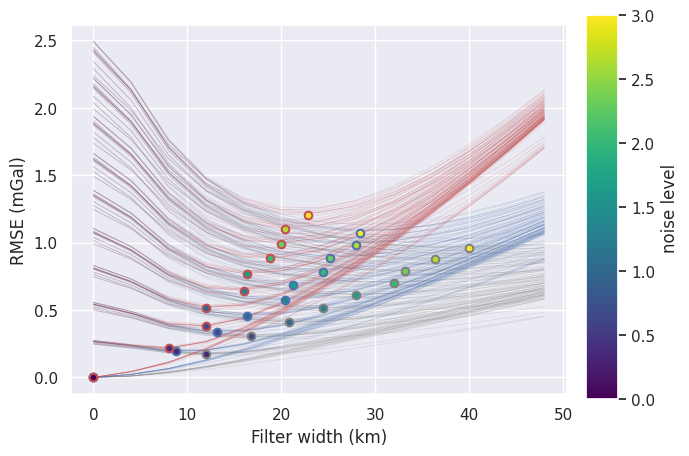

In [ ]:
fig, ax = plt.subplots()

norm = plt.Normalize(
    vmin=sampled_params_df_no_regional.grav_noise_levels.values.min(),
    vmax=sampled_params_df_no_regional.grav_noise_levels.values.max(),
)

grouped = sampled_params_df_no_regional.groupby("grav_noise_levels")
for name, group in grouped:
    best_filters = []
    best_rmses = []
    for _i, row in group.iterrows():
        # load data
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)

        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_rmse = filter_width_trials.iloc[best_ind].rmse
        best_filters.append(best_filter_width)
        best_rmses.append(best_rmse)

        ax.plot(
            filter_width_trials.filt_width / 1e3,
            filter_width_trials.rmse,
            color="gray",
            alpha=0.2,
            # linestyle='--',
            linewidth=0.5,
        )

    color = plt.cm.viridis(norm(name))  # pylint: disable=no-member
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=np.mean(best_rmses),
        marker="o",
        edgecolor="gray",
        linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
    )

grouped = sampled_params_df_medium_regional.groupby("grav_noise_levels")
for name, group in grouped:
    best_filters = []
    best_rmses = []
    for _i, row in group.iterrows():
        # load data
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)

        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_rmse = filter_width_trials.iloc[best_ind].rmse
        best_filters.append(best_filter_width)
        best_rmses.append(best_rmse)

        ax.plot(
            filter_width_trials.filt_width / 1e3,
            filter_width_trials.rmse,
            color="b",
            alpha=0.2,
            # linestyle='--',
            linewidth=0.5,
        )

    color = plt.cm.viridis(norm(name))  # pylint: disable=no-member
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=np.mean(best_rmses),
        marker="o",
        edgecolor="b",
        linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
    )

grouped = sampled_params_df_strong_regional.groupby("grav_noise_levels")
for name, group in grouped:
    best_filters = []
    best_rmses = []
    for _i, row in group.iterrows():
        # load data
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)

        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_rmse = filter_width_trials.iloc[best_ind].rmse
        best_filters.append(best_filter_width)
        best_rmses.append(best_rmse)

        ax.plot(
            filter_width_trials.filt_width / 1e3,
            filter_width_trials.rmse,
            color="r",
            alpha=0.2,
            # linestyle='--',
            linewidth=0.5,
        )

    color = plt.cm.viridis(norm(name))  # pylint: disable=no-member
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=np.mean(best_rmses),
        marker="o",
        edgecolor="r",
        linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
    )

ax.set_xlabel("Filter width (km)")
ax.set_ylabel("RMSE (mGal)")
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
cax = fig.add_axes([0.93, 0.1, 0.05, 0.8])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("noise level")

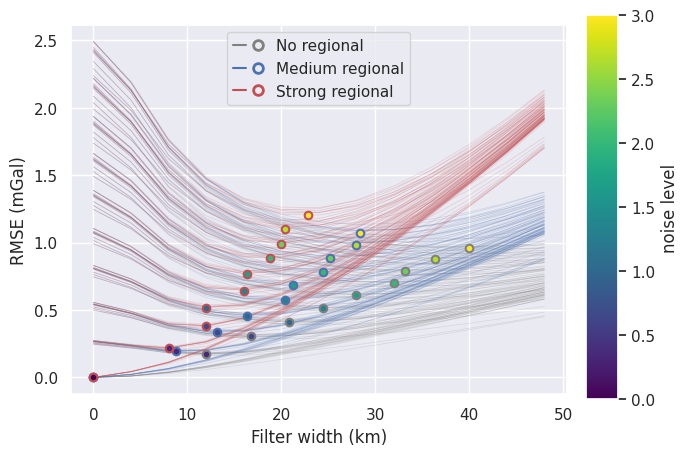

In [50]:
# create manual symbols for legend
symbols = []
line = mpl.lines.Line2D(
    [0],
    [0],
    color="gray",
)
point = mpl.lines.Line2D(
    [0],
    [0],
    marker="o",
    markersize=7,
    markeredgecolor="gray",
    markerfacecolor="None",
    markeredgewidth=2,
    linestyle="",
)
symbols.append((line, point))

line = mpl.lines.Line2D(
    [0],
    [0],
    color="b",
)
point = mpl.lines.Line2D(
    [0],
    [0],
    marker="o",
    markersize=7,
    markeredgecolor="b",
    markerfacecolor="None",
    markeredgewidth=2,
    linestyle="",
)
symbols.append((line, point))

line = mpl.lines.Line2D(
    [0],
    [0],
    color="r",
)
point = mpl.lines.Line2D(
    [0],
    [0],
    marker="o",
    markersize=7,
    markeredgecolor="r",
    markerfacecolor="None",
    markeredgewidth=2,
    linestyle="",
)
symbols.append((line, point))

ax.legend(
    symbols,
    ["No regional", "Medium regional", "Strong regional"],
    handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
)


fig

Text(0, 0.5, 'Gravity noise level (mGal)')

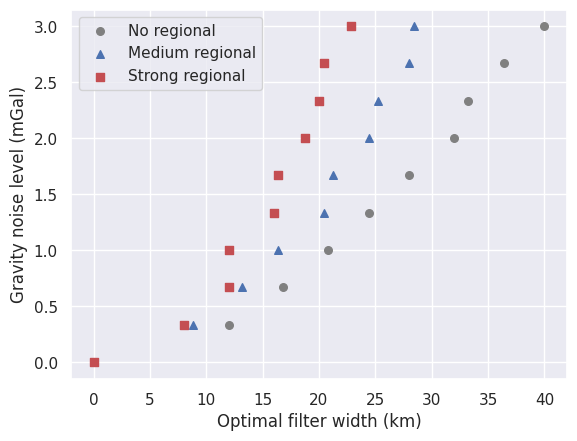

In [ ]:
fig, ax = plt.subplots()

grouped = sampled_params_df_no_regional.groupby("grav_noise_levels")
for j, (name, group) in enumerate(grouped):
    best_filters = []
    for i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    color = "gray"
    label = "No regional" if j == 0 else None
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=name,
        marker="o",
        # edgecolor="black",
        # linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
        label=label,
    )

grouped = sampled_params_df_medium_regional.groupby("grav_noise_levels")
for j, (name, group) in enumerate(grouped):
    best_filters = []
    for _i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    color = "b"
    label = "Medium regional" if j == 0 else None
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=name,
        marker="^",
        # edgecolor="black",
        # linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
        label=label,
    )


grouped = sampled_params_df_strong_regional.groupby("grav_noise_levels")
for j, (name, group) in enumerate(grouped):
    best_filters = []
    for _i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    color = "r"
    label = "Strong regional" if j == 0 else None
    ax.scatter(
        x=np.mean(best_filters) / 1e3,
        y=name,
        marker="s",
        # edgecolor="black",
        # linewidth=1.5,
        color=color,
        s=30,
        zorder=20,
        label=label,
    )

ax.legend()
ax.set_xlabel("Optimal filter width (km)")
ax.set_ylabel("Gravity noise level (mGal)")
# ax.set_title("Optimal filter width")

Text(0.5, 1.0, 'Optimal filter width')

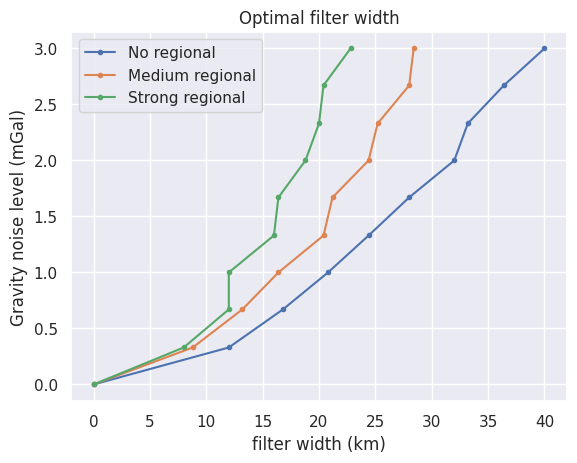

In [ ]:
fig, ax = plt.subplots()

dfs = []
grouped = sampled_params_df_no_regional.groupby("grav_noise_levels")
for _j, (name, group) in enumerate(grouped):
    best_filters = []
    for _i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    dfs.append(
        pd.DataFrame(
            [
                {
                    "filter_width": np.mean(best_filters) / 1e3,
                    "noise": name,
                    "regional": "none",
                }
            ]
        )
    )

grouped = sampled_params_df_medium_regional.groupby("grav_noise_levels")
for _j, (name, group) in enumerate(grouped):
    best_filters = []
    for _i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    dfs.append(
        pd.DataFrame(
            [
                {
                    "filter_width": np.mean(best_filters) / 1e3,
                    "noise": name,
                    "regional": "medium",
                }
            ]
        )
    )

grouped = sampled_params_df_strong_regional.groupby("grav_noise_levels")
for _j, (name, group) in enumerate(grouped):
    best_filters = []
    for _i, row in group.iterrows():
        filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
        best_ind = filter_width_trials.rmse.idxmin()
        best_filter_width = filter_width_trials.iloc[best_ind].filt_width
        best_filters.append(best_filter_width)

    dfs.append(
        pd.DataFrame(
            [
                {
                    "filter_width": np.mean(best_filters) / 1e3,
                    "noise": name,
                    "regional": "strong",
                }
            ]
        )
    )

df = pd.concat(dfs)

df_subset = df[df.regional == "none"]
ax.plot(
    df_subset.filter_width,
    df_subset.noise,
    ".-",
    label="No regional",
)
df_subset = df[df.regional == "medium"]
ax.plot(
    df_subset.filter_width,
    df_subset.noise,
    ".-",
    label="Medium regional",
)
df_subset = df[df.regional == "strong"]
ax.plot(
    df_subset.filter_width,
    df_subset.noise,
    ".-",
    label="Strong regional",
)

ax.legend()
ax.set_xlabel("filter width (km)")
ax.set_ylabel("Gravity noise level (mGal)")
ax.set_title("Optimal filter width")

In [53]:
# fig, ax = plt.subplots()

# grouped = sampled_params_df_no_regional.groupby("grav_noise_levels")
# for j, (name, group) in enumerate(grouped):
#     best_filters = []
#     best_rmses = []
#     for i, row in group.iterrows():
#         filter_width_trials = pd.read_csv(row.filter_width_trials_fname)
#         best_ind = filter_width_trials.rmse.idxmin()
#         best_rmse = filter_width_trials.iloc[best_ind].rmse
#         best_filters.append(best_filter_width)
#         best_rmses.append(best_rmse)

#     color = 'gray'
#     if j == 0:
#         label="No regional"
#     else:
#         label=None
#     color = plt.cm.viridis(norm(best_rmses)) # pylint: disable=no-member
#     ax.scatter(
#         x=np.mean(best_filters)/1e3,
#         y=name,
#         marker="o",
#         # edgecolor="black",
#         # linewidth=1.5,
#         color=color,
#         s=30,
#         zorder=20,
#         label=label,
#     )

# grouped = sampled_params_df_medium_regional.groupby("grav_noise_levels")

# grouped = sampled_params_df_strong_regional.groupby("grav_noise_levels")


# ax.legend()
# ax.set_xlabel("filter width (km)")
# ax.set_ylabel("Gravity noise level (mGal)")
# ax.set_title("Optimal filter width")

## No regional

In [54]:
sampled_params_df_no_regional[
    [
        "final_inversion_rmse",
        "final_inversion_topo_improvement_rmse",
    ]
].describe()

,final_inversion_rmse,final_inversion_topo_improvement_rmse
count,100.000000,100.000000
mean,20.844716,5.132646
std,9.947129,9.947129
min,3.321030,-18.871279
25%,14.488193,1.139340
50%,19.577218,6.400145
75%,24.838023,11.489170
max,44.848642,22.656333


In [55]:
sampled_params_df_no_regional.columns

Index(['grav_line_numbers', 'grav_noise_levels', 'grav_df_fname',
       'grav_survey_df_fname', 'grav_line_spacing',
       'filter_width_trials_fname', 'best_filter_width', 'grav_data_loss_rmse',
       'grav_data_loss_mae', 'true_density_results_fname',
       'true_density_inverted_bathymetry_fname',
       'true_density_constraints_rmse', 'true_density_inversion_rmse',
       'grav_proximity', 'final_inversion_fname',
       'final_inverted_bathymetry_fname', 'final_inversion_constraints_rmse',
       'final_inversion_rmse', 'residual_error', 'flight_kms',
       'flight_kms_per_10000sq_km',
       'inversion_rmse_dif_true_vs_optimal_density',
       'final_inversion_topo_improvement_rmse'],
      dtype='object')

In [56]:
np.linspace(5, 55, 6)

array([ 5., 15., 25., 35., 45., 55.])

In [59]:
df = sampled_params_df_no_regional[
    ["grav_proximity", "grav_line_spacing"]
].drop_duplicates()
df = df.sort_values("grav_line_spacing", ascending=False)
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {
                "grav_line_spacing": np.arange(
                    round(df.grav_line_spacing.min()),
                    round(df.grav_line_spacing.max()) + 1,
                    1,
                )
            }
        ),
    ]
).drop_duplicates(subset="grav_line_spacing")
df = df.sort_values("grav_line_spacing", ascending=False).reset_index(drop=True)

df = synthetic.scipy_interp1d(
    df,
    to_interp="grav_proximity",
    interp_on="grav_line_spacing",
    method="cubic",
)
df = df[["grav_line_spacing", "grav_proximity"]]

df = df[
    df.grav_line_spacing.isin(
        np.arange(
            round(sampled_params_df_no_regional.grav_line_spacing.min()),
            round(sampled_params_df_no_regional.grav_line_spacing.max()) + 1,
            10,
        )
    )
]
df

,grav_line_spacing,grav_proximity
3,56.0,8.016317
13,46.0,6.580356
24,36.0,5.139188
35,26.0,3.736880
46,16.0,2.294572
60,6.0,0.851066


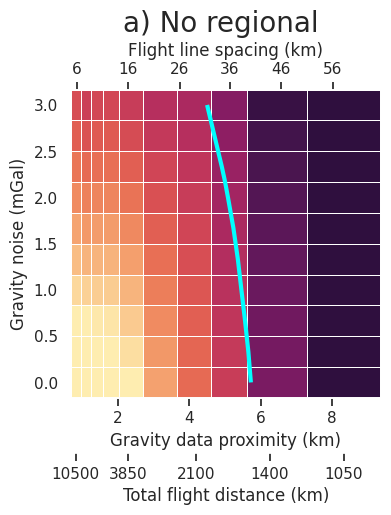

In [60]:
fig = synth_plotting.plot_2var_ensemble(
    sampled_params_df_no_regional,
    figsize=figsize,
    x="grav_proximity",
    x_title="Gravity data proximity (km)",
    y="grav_noise_levels",
    y_title="Gravity noise (mGal)",
    background="final_inversion_rmse",
    background_title="Bathymetry RMSE (m)",
    background_robust=True,
    plot_contours=contours,
    contour_color="cyan",
    background_cpt_lims=cpt_lims,
    colorbar=False,
    constrained_layout=False,
)
plt.gcf().text(0.5, 1.01, "a) No regional", fontsize=20, va="bottom", ha="center")
ax = fig.get_axes()[0]

# add second x axis with flight line spacing
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
x_tick_vals = df.grav_proximity.unique()
x_tick_labels = df.grav_line_spacing.unique()
x_tick_labels = [int(x) for x in x_tick_labels]
ax2.set_xticks(x_tick_vals)
ax2.set_xticklabels(x_tick_labels)
ax2.grid(False)
ax2.set_xlabel("Flight line spacing (km)")

# add third x axis for flight distance
ax3 = ax.twiny()
ax3.set_xlim(ax.get_xlim())
x_tick_vals = sampled_params_df_no_regional.grav_proximity.unique()
x_tick_labels = sampled_params_df_no_regional.flight_kms.unique()
inds_to_remove = [-2, -3, -4, -6, -8]
x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
x_tick_labels = [round(x) for x in x_tick_labels]
ax3.set_xticks(x_tick_vals)
ax3.set_xticklabels(x_tick_labels)
ax3.grid(False)
ax3.set_xlabel("Total flight distance (km)")
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("outward", 40))

# specify y ticks
ax.set_yticks(np.arange(0, 3.5, 0.5))

fig.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_no_regional_2var.png",
    bbox_inches="tight",
    dpi=300,
)

In [61]:
# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_no_regional,
#     figsize=figsize,
#     # x="flight_kms_per_10000sq_km",
#     # x_title="Flight km per 10000 $km^2$",
#     x="flight_kms",
#     x_title="Flight distance (km)",
#     y="grav_noise_levels",
#     y_title="Gravity noise (mGal)",
#     background="final_inversion_rmse",
#     background_title="Bathymetry RMSE (m)",
#     background_robust=True,
#     plot_contours=contours,
#     contour_color="cyan",
#     background_cpt_lims=cpt_lims,
#     colorbar=False,
#     constrained_layout=False,
# )
# plt.gcf().text(0.5, .92, "a) No regional", fontsize=20, va="bottom", ha="center")

# ax = fig.get_axes()[0]

# x = "flight_kms"
# x2 = "grav_proximity"

# df = sampled_params_df_no_regional[[x2, x]].drop_duplicates()

# a,b = df[x].min(), df[x].max()

# df = pd.concat(
#     [df, pd.DataFrame({x: ax.get_xticks()})]
# ).drop_duplicates(subset=[x])

# df = df[df[x].between(a, b)]

# df = synthetic.scipy_interp1d(
#     df,
#     to_interp=x2,
#     interp_on=x,
#     method="cubic",
# )
# df = df[df[x].isin(ax.get_xticks())].sort_values(x2)

# # add second x axis for line spacing
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())

# ax2.set_xticks(df[x])
# ax2.set_xticklabels([round(i,1) for i in df[x2]])
# ax2.grid(False)
# ax2.set_xlabel("Median proximity (km)")
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))

# # specify y ticks
# yvals = list(sampled_params_df_no_regional.grav_noise_levels.unique())[::2]
# yvals.append(sampled_params_df_no_regional.grav_noise_levels.unique()[-1])
# ax.set_yticks(yvals)
# ax.set_yticklabels([round(x, 1) for x in yvals])
# ax.tick_params(
#     axis="both",
#     which="both",
#     length=5,
#     bottom=True,
#     left=True,
# )
# plt.minorticks_off()

# fig.savefig(
#     "../paper/figures/Ross_Sea_noise_vs_spacing_no_regional_2var.png",
#     bbox_inches="tight",
#     dpi=300,
# )

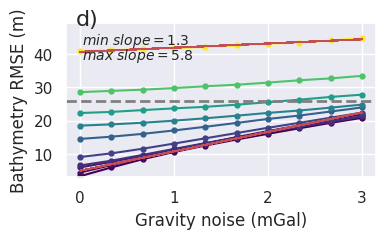

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_no_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x="grav_noise_levels",
    x_label="Gravity noise (mGal)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_line_spacing",
    cbar_label="Line spacing (km)",
    # groupby_col="median_grav_distance",
    # cbar_label="Median gravity distance (m)",
    # groupby_col="flight_kms_per_10000sq_km",
    # cbar_label="Flight km per 10000 $km^2$",
    trend_line=True,
    # slope_mean=True,
    slope_min_max=True,
    slope_decimals=1,
    # slope_max=True,
    horizontal_line=contours,
    # horizontal_line_label="Starting MAE",
    # horizontal_line_label="Starting RMSE",
    # horizontal_line_label_loc="lower right",
    y_lims=line_plot_ylims,
    colorbar=False,
)
plt.gcf().text(0.15, 0.95, "d)", fontsize=16, va="top", ha="left")

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_no_regional_bathy_error_vs_grav_noise.png",
    bbox_inches="tight",
    dpi=300,
)

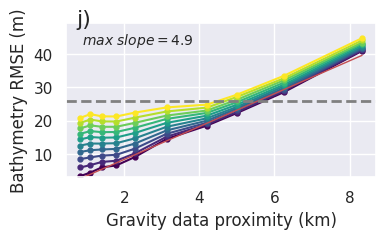

In [ ]:
x = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_no_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Gravity data proximity (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    # logx=True,
    colorbar=False,
    trend_line=True,
    slope_max=True,
    # slope_min=True,
    # slope_min_max=True,
    # trend_line_text_loc=(0.5, 0.95),
    slope_decimals=1,
)
plt.gcf().text(0.15, 0.95, "j)", fontsize=16, va="top", ha="left")

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_no_regional_bathy_error_vs_grav_spacing_2.png",
    bbox_inches="tight",
    dpi=300,
)

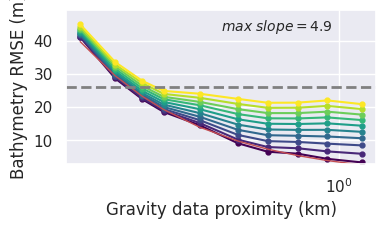

In [ ]:
x = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_no_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Gravity data proximity (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    logx=True,
    flipx=True,
    colorbar=False,
    trend_line=True,
    slope_max=True,
    trend_line_text_loc=(0.5, 0.95),
    slope_decimals=1,
)

In [66]:
sampled_params_df_no_regional[
    ["grav_proximity", "grav_line_spacing", "flight_kms"]
].drop_duplicates()

,grav_proximity,grav_line_spacing,flight_kms
0,8.333333,58.333333,1050.0
10,6.250800,43.750000,1400.0
20,5.001000,35.000000,1750.0
30,4.200000,29.166667,2100.0
40,3.126600,21.875000,2800.0
50,2.281510,15.909091,3850.0
60,1.788512,12.500000,4900.0
70,1.400000,9.722222,6300.0
80,1.096652,7.608696,8050.0
90,0.824621,5.833333,10500.0


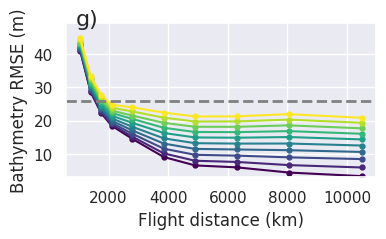

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_no_regional,
    figsize=(figsize[0], figsize[1] / 2),
    # x="flight_kms_per_10000sq_km",
    # x_label="Flight km per 10000 $km^2$",
    x="flight_kms",
    x_label="Flight distance (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    # logx=True,
    colorbar=False,
)
plt.gcf().text(0.15, 0.95, "g)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_no_regional_bathy_error_vs_grav_spacing.png",
    bbox_inches="tight",
    dpi=300,
)

## Medium regional

In [68]:
sampled_params_df_medium_regional[
    [
        "final_inversion_rmse",
        "final_inversion_topo_improvement_rmse",
    ]
].describe()

,final_inversion_rmse,final_inversion_topo_improvement_rmse
count,100.000000,100.000000
mean,18.986304,6.991059
std,5.139812,5.139812
min,8.892173,-4.158308
25%,15.727752,4.260268
50%,19.088861,6.888502
75%,21.717095,10.249611
max,30.135671,17.085190


In [71]:
cols = [
    "grav_proximity",
    "grav_line_spacing",
    "grav_line_numbers",
    "flight_kms_per_10000sq_km",
]
sampled_params_df_medium_regional[cols]

,grav_proximity,grav_line_spacing,grav_line_numbers,flight_kms_per_10000sq_km
0,8.333333,58.333333,3,350.0
1,8.333333,58.333333,3,350.0
2,8.333333,58.333333,3,350.0
3,8.333333,58.333333,3,350.0
4,8.333333,58.333333,3,350.0
...,...,...,...,...
95,0.824621,5.833333,30,3500.0
96,0.824621,5.833333,30,3500.0
97,0.824621,5.833333,30,3500.0
98,0.824621,5.833333,30,3500.0


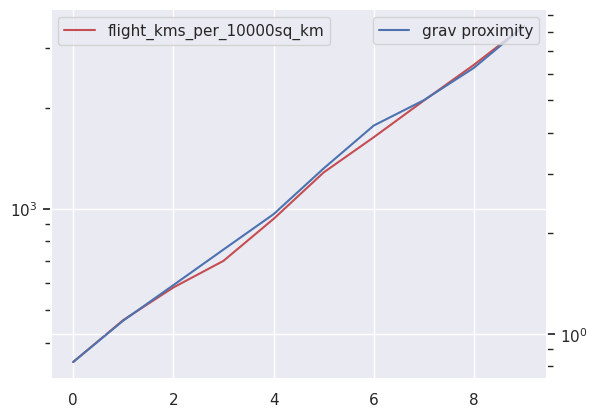

In [ ]:
fig, ax = plt.subplots()

ax.plot(
    sampled_params_df_medium_regional.flight_kms_per_10000sq_km.drop_duplicates().reset_index(
        drop=True,
    ),
    c="r",
    label="flight_kms_per_10000sq_km",
)

ax2 = ax.twinx()

ax2.plot(
    sampled_params_df_medium_regional.grav_proximity.drop_duplicates()[
        ::-1
    ].reset_index(
        drop=True,
    ),
    label="grav proximity",
)
ax2.set_yscale("log")
ax.set_yscale("log")
ax.legend()
ax2.legend(loc="upper right")
# ax2.invert_xaxis()

In [74]:
sampled_params_df_medium_regional.describe()

,grav_line_numbers,grav_noise_levels,grav_line_spacing,grav_proximity,best_filter_width,grav_data_loss_rmse,grav_data_loss_mae,regional_error,residual_error,regional_rms,true_density_constraints_rmse,true_density_inversion_rmse,best_density_contrast,density_estimation_constraints_rmse,density_estimation_inversion_rmse,final_inversion_constraints_rmse,final_inversion_rmse,flight_kms,flight_kms_per_10000sq_km,final_inversion_topo_improvement_rmse
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12.200000,1.500000,23.969834,3.430303,18600.000000,1.596717,1.016229,1.632872,1.632872,1.841094e+01,1.537329,20.181453,2179.490000,368.473891,282.586461,1.512516,18.986304,4270.000000,1423.333333,6.991059
std,8.596452,0.962604,16.579504,2.368128,8814.588459,1.265818,0.777845,1.176320,1.176320,3.570612e-15,0.653670,5.781063,83.220226,3.290907,4.796654,0.712082,5.139812,3008.758259,1002.919420,5.139812
min,3.000000,0.000000,5.833333,0.824621,0.000000,0.064137,0.030193,0.493319,0.493319,1.841094e+01,0.819895,9.514780,2012.000000,362.076434,271.461079,0.836704,8.892173,1050.000000,350.000000,-4.158308
25%,5.000000,0.670000,9.722222,1.400000,12000.000000,0.703531,0.495050,0.828962,0.828962,1.841094e+01,1.108151,16.550782,2113.250000,365.848851,280.052187,1.088880,15.727752,1750.000000,583.333333,4.260268
50%,9.500000,1.500000,18.892045,2.704055,20000.000000,1.083513,0.771600,1.113426,1.113426,1.841094e+01,1.481004,20.073716,2201.500000,368.394380,283.370931,1.411650,19.088861,3325.000000,1108.333333,6.888502
75%,18.000000,2.330000,35.000000,5.001000,24000.000000,2.126243,1.277122,2.131809,2.131809,1.841094e+01,1.675959,22.792000,2229.000000,370.767977,285.171563,1.599744,21.717095,6300.000000,2100.000000,10.249611
max,30.000000,3.000000,58.333333,8.333333,32000.000000,4.665176,3.036458,4.562088,4.562088,1.841094e+01,4.282557,33.106040,2317.000000,376.108357,292.515401,4.725426,30.135671,10500.000000,3500.000000,17.085190


In [75]:
df = sampled_params_df_medium_regional[
    ["grav_proximity", "grav_line_spacing"]
].drop_duplicates()
df = df.sort_values("grav_line_spacing", ascending=False)
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {
                "grav_line_spacing": np.arange(
                    round(df.grav_line_spacing.min()),
                    round(df.grav_line_spacing.max()) + 1,
                    1,
                )
            }
        ),
    ]
).drop_duplicates(subset="grav_line_spacing")
df = df.sort_values("grav_line_spacing", ascending=False).reset_index(drop=True)

df = synthetic.scipy_interp1d(
    df,
    to_interp="grav_proximity",
    interp_on="grav_line_spacing",
    method="cubic",
)
df = df[["grav_line_spacing", "grav_proximity"]]

df = df[
    df.grav_line_spacing.isin(
        np.arange(
            round(sampled_params_df_medium_regional.grav_line_spacing.min()),
            round(sampled_params_df_medium_regional.grav_line_spacing.max()) + 1,
            10,
        )
    )
]
df

,grav_line_spacing,grav_proximity
3,56.0,8.016317
13,46.0,6.580356
24,36.0,5.139188
35,26.0,3.736880
46,16.0,2.294572
60,6.0,0.851066


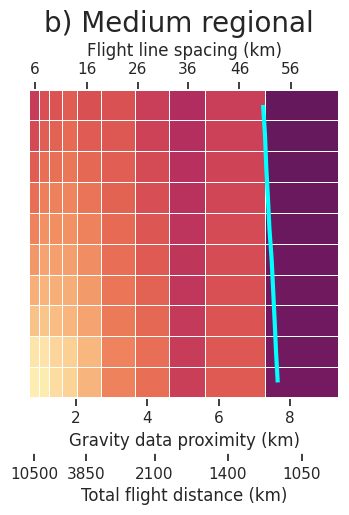

In [76]:
fig = synth_plotting.plot_2var_ensemble(
    sampled_params_df_medium_regional,
    figsize=figsize,
    x="grav_proximity",
    x_title="Gravity data proximity (km)",
    y="grav_noise_levels",
    y_title="Gravity noise (mGal)",
    background="final_inversion_rmse",
    background_title="Bathymetry RMSE (m)",
    background_robust=True,
    plot_contours=contours,
    contour_color="cyan",
    background_cpt_lims=cpt_lims,
    colorbar=False,
    constrained_layout=False,
)
plt.gcf().text(0.5, 1.01, "b) Medium regional", fontsize=20, va="bottom", ha="center")
ax = fig.get_axes()[0]

# add second x axis with flight line spacing
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
x_tick_vals = df.grav_proximity.unique()
x_tick_labels = df.grav_line_spacing.unique()
x_tick_labels = [int(x) for x in x_tick_labels]
ax2.set_xticks(x_tick_vals)
ax2.set_xticklabels(x_tick_labels)
ax2.grid(False)
ax2.set_xlabel("Flight line spacing (km)")

# add third x axis for flight distance
ax3 = ax.twiny()
ax3.set_xlim(ax.get_xlim())
x_tick_vals = sampled_params_df_medium_regional.grav_proximity.unique()
x_tick_labels = sampled_params_df_medium_regional.flight_kms.unique()
inds_to_remove = [-2, -3, -4, -6, -8]
x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
x_tick_labels = [round(x) for x in x_tick_labels]
ax3.set_xticks(x_tick_vals)
ax3.set_xticklabels(x_tick_labels)
ax3.grid(False)
ax3.set_xlabel("Total flight distance (km)")
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("outward", 40))

ax.yaxis.set_visible(False)

fig.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_2var.png",
    bbox_inches="tight",
    dpi=300,
)

In [77]:
# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_medium_regional,
#     figsize=figsize,
#     x="flight_kms",
#     x_title="Flight distance (km)",
#     y="grav_noise_levels",
#     y_title="Gravity noise (mGal)",
#     background="final_inversion_rmse",
#     background_title="Bathymetry RMSE (m)",
#     background_robust=True,
#     plot_contours=contours,
#     contour_color="cyan",
#     background_cpt_lims=cpt_lims,
#     colorbar=False,
#     constrained_layout=False,
# )
# plt.gcf().text(0.5, .92, "b) Medium regional", fontsize=20, va="bottom", ha="center")

# ax = fig.get_axes()[0]

# x = "flight_kms"
# x2 = "grav_proximity"

# df = sampled_params_df_medium_regional[[x2, x]].drop_duplicates()

# a,b = df[x].min(), df[x].max()

# df = pd.concat(
#     [df, pd.DataFrame({x: ax.get_xticks()})]
# ).drop_duplicates(subset=[x])

# df = df[df[x].between(a, b)]

# df = synthetic.scipy_interp1d(
#     df,
#     to_interp=x2,
#     interp_on=x,
#     method="cubic",
# )
# df = df[df[x].isin(ax.get_xticks())].sort_values(x2)

# # add second x axis for line spacing
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())

# ax2.set_xticks(df[x])
# ax2.set_xticklabels([round(i,1) for i in df[x2]])
# ax2.grid(False)
# ax2.set_xlabel("Median proximity (km)")
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))

# # specify y ticks
# yvals = list(sampled_params_df_medium_regional.grav_noise_levels.unique())[::2]
# yvals.append(sampled_params_df_medium_regional.grav_noise_levels.unique()[-1])
# ax.set_yticks(yvals)
# ax.set_yticklabels([round(x, 1) for x in yvals])
# ax.tick_params(
#     axis="both",
#     which="both",
#     length=5,
#     bottom=True,
#     left=True,
# )
# plt.minorticks_off()

# ax.scatter(
#     # x = 1483.3, # flight km per 10000 km2
#     x = 4450, # flight km
#     y = 0.3, # grav_noise_level
#     marker="^",
#     s=100,
#     color="b",
#     linewidth=1,
#     edgecolor='k',
#     label="Test 5",
# )
# ax.legend()

# ax.yaxis.set_visible(False)

# fig.savefig(
#     "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_2var.png",
#     bbox_inches="tight",
#     dpi=300,
# )

In [ ]:
# ax2 = ax.twiny()
# ax2.set_xticks([vals[0], vals[4], vals[6], vals[8], vals[9]])

# vals = [int(x) for x in sampled_params_df_low_regional.grav_line_spacing.unique()]
# ax2.set_xticklabels([vals[0], vals[4], vals[6], vals[8], vals[9]])
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))
# ax2.set_xlim(ax.get_xlim())
# ax2.grid(False)
# ax2.set_xlabel("Line spacing (km)")

# fig.savefig("../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_2var.png", bbox_inches="tight")
# fig

In [ ]:
# plt.savefig("../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_2var.png", bbox_inches="tight")

In [ ]:
# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_medium_regional,
#     figsize = (6,4),
#     x="grav_line_spacing",
#     y="grav_noise_levels",
#     x_title="Line spacing (km)",
#     y_title="Gravity noise (mGal)",

#     background="topo_improvement_mae",
#     background_title="Topo improvement (m)",

#     background_robust=True,
#     background_cmap="cmo.matter_r",
#     plot_contours=[0],
#     contour_color="cyan",
# )
# bbox = dict(facecolor='lightgray', boxstyle="round")
# plt.gcf().text(0.3, -.05, "many lines", fontsize=12, va="center", ha="right", bbox=bbox)
# plt.gcf().text(0.6, -.05, "few lines", fontsize=12, va="center", ha="left", bbox=bbox)

# plt.savefig('../paper/figures/ensemble_4_medium_regional_2var.png')

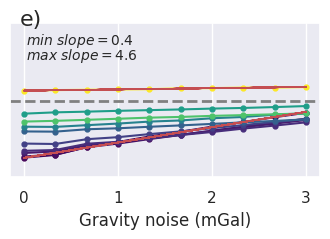

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_medium_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x="grav_noise_levels",
    x_label="Gravity noise (mGal)",
    # y="inversion_mae",
    # y_label="Bathymetry MAE (m)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_line_spacing",
    cbar_label="Line spacing (km)",
    # groupby_col="flight_kms_per_10000sq_km",
    # cbar_label="Flight km per 10000 $km^2$",
    trend_line=True,
    horizontal_line=contours,
    # horizontal_line_label="Starting MAE",
    # horizontal_line_label="Starting RMSE",
    # horizontal_line_label_loc="lower right",
    y_lims=line_plot_ylims,
    colorbar=False,
    # slope_mean=True,
    slope_min_max=True,
    slope_decimals=1,
)
plt.gcf().text(0.15, 0.95, "e)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]
ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_bathy_error_vs_grav_noise.png",
    bbox_inches="tight",
    dpi=300,
)

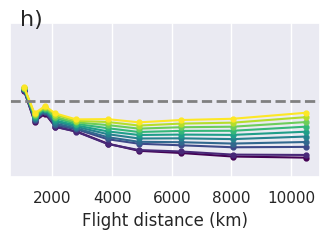

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_medium_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x="flight_kms",
    x_label="Flight distance (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    # flipx=True,
    colorbar=False,
)
plt.gcf().text(0.15, 0.95, "h)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_bathy_error_vs_grav_spacing.png",
    bbox_inches="tight",
    dpi=300,
)

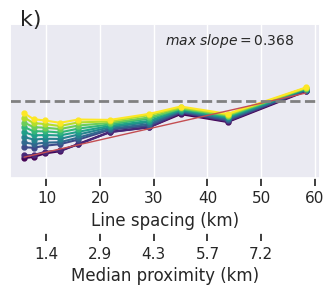

In [ ]:
x = "grav_line_spacing"
x2 = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_medium_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Line spacing (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    # horizontal_line_label="Starting RMSE",
    # horizontal_line_label_loc="upper right",
    y_lims=line_plot_ylims,
    # logx=True,
    colorbar=False,
    trend_line=True,
    slope_max=True,
    trend_line_text_loc=(0.5, 0.95),
)
plt.gcf().text(0.15, 0.95, "k)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

df = sampled_params_df_medium_regional[[x2, x]].drop_duplicates()

a, b = df[x].min(), df[x].max()

df = pd.concat([df, pd.DataFrame({x: ax.get_xticks()})]).drop_duplicates(subset=[x])

df = df[df[x].between(a, b)]

df = synthetic.scipy_interp1d(
    df,
    to_interp=x2,
    interp_on=x,
    method="cubic",
)
df = df[df[x].isin(ax.get_xticks())].sort_values(x2)

# add second x axis for line spacing
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ax2.set_xticks(df[x])
ax2.set_xticklabels([round(i, 1) for i in df[x2]])
ax2.grid(False)
ax2.set_xlabel("Median proximity (km)")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))

ax.yaxis.set_visible(False)

# plt.savefig(
#     "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_bathy_error_vs_grav_spacing_2.png",
#     bbox_inches="tight",
#     dpi=300,
# )

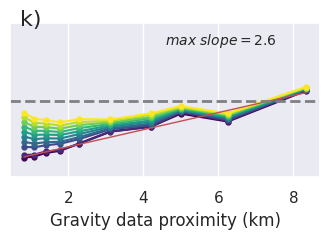

In [ ]:
x = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_medium_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Gravity data proximity (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    # logx=True,
    colorbar=False,
    trend_line=True,
    slope_max=True,
    trend_line_text_loc=(0.5, 0.95),
    slope_decimals=1,
)
plt.gcf().text(0.15, 0.95, "k)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_medium_regional_bathy_error_vs_grav_spacing_2.png",
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
# # subplots showing inverted bathymetry's
# grids = []
# cbar_labels = []
# row_titles = []
# column_titles = []

# # iterate over the ensemble starting with high noise, low line numbers
# # row per noise level and column per line spacing
# for i, row in sampled_params_df_medium_regional.sort_values(by=["grav_noise_levels", "grav_line_spacing"], ascending=False,).iterrows():
#     inverted_bathymetry = xr.open_dataarray(row.inverted_bathymetry_fname)
#     reg = vd.pad_region(inversion_region, -3*spacing)
#     # reg = inversion_region
#     inverted_bathymetry = inverted_bathymetry.sel(
#         easting=slice(reg[0], reg[1]),
#         northing=slice(reg[2], reg[3]),
#     )
#     # add to lists
#     grids.append(inverted_bathymetry)
#     cbar_labels.append(f"MAE: {round(row.inversion_mae,2)} (m)")
#     if i % np.sqrt(len(sampled_params_df_medium_regional)) == 0:
#         column_titles.append(f"Spacing: {round(row.grav_line_spacing)} km")
#     if i < np.sqrt(len(sampled_params_df_medium_regional)):
#         row_titles.append(f"Noise: {round(row.grav_noise_levels,1)} mGal")

# fig = maps.subplots(
#     grids,
#     fig_height=8,
#     fig_title="Inverted bathymetry",
#     fig_title_font="75p,Helvetica-Bold,black",
#     fig_title_y_offset="5c",
#     cbar_labels=cbar_labels,
#     cmap="rain",
#     reverse_cpt=True,
#     # colorbar=False,
#     # hist=True,
#     cpt_lims=polar_utils.get_combined_min_max(grids, robust=True),
#     cbar_font="18p,Helvetica,black",
#     row_titles=row_titles,
#     column_titles=column_titles,
#     row_titles_font="25p,Helvetica,black",
#     column_titles_font="25p,Helvetica,black",
# )
# fig.show()

In [ ]:
# # subplots showing inverted bathymetry's
# grids = []
# cbar_labels = []
# row_titles = []
# column_titles = []

# df = sampled_params_df_medium_regional
# # iterate over the ensemble starting with high noise, small line spacing
# # row per noise level and column per line spacing
# for i, row in df.sort_values(
#     by=["grav_noise_levels", "grav_line_spacing"], ascending=[False, True]
# ).iterrows():
#     inverted_bathymetry = xr.open_dataarray(row.inverted_bathymetry_fname)

#     dif = bathymetry - inverted_bathymetry

#     # reg = vd.pad_region(inversion_region, -3*spacing)
#     reg = inversion_region
#     inverted_bathymetry = inverted_bathymetry.sel(
#         easting=slice(reg[0], reg[1]),
#         northing=slice(reg[2], reg[3]),
#     )
#     dif = dif.sel(
#         easting=slice(reg[0], reg[1]),
#         northing=slice(reg[2], reg[3]),
#     )
#     # add to lists
#     grids.append(inverted_bathymetry)
#     grids.append(dif)
#     cbar_labels.append(f"MAE: {round(row.inversion_mae,2)} m")
#     cbar_labels.append(" ")
#     if i % np.sqrt(len(df)) == 0:
#         column_titles.append(round(row.grav_line_spacing))
#         column_titles.append(" ")
#     if i < np.sqrt(len(df)):
#         row_titles.append(round(row.grav_noise_levels, 1))
#         # row_titles.append(" ")

# fig = maps.subplots(
#     grids,
#     dims=(np.sqrt(len(df)), 2 * np.sqrt(len(df))),
#     fig_height=8,
#     fig_title="Medium regional",
#     fig_x_axis_title="Flight line spacing (km)",
#     fig_y_axis_title="Gravity noise (mGal)",
#     fig_title_font="100p,Helvetica-Bold,black",
#     fig_axis_title_font="80p,Helvetica-Bold,black",
#     fig_title_y_offset="8c",
#     fig_x_axis_title_y_offset="2.5c",
#     fig_y_axis_title_x_offset="3c",
#     cbar_labels=cbar_labels,
#     cmaps=[x for xs in [["rain", "balance+h0"] for x in range(len(df))] for x in xs],
#     reverse_cpt=True,
#     # colorbar=False,
#     # hist=True,
#     # cpt_lims=polar_utils.get_combined_min_max(grids, robust=True),
#     cpt_limits=[
#         x
#         for xs in [
#             [
#                 polar_utils.get_combined_min_max(grids[::2], robust=True),
#                 polar_utils.get_combined_min_max(grids[1::2], robust=True),
#             ]
#             for x in range(len(df))
#         ]
#         for x in xs
#     ],
#     cbar_font="45p,Helvetica,black",
#     row_titles=row_titles,
#     column_titles=column_titles,
#     row_titles_font="70p,Helvetica,black",
#     column_titles_font="70p,Helvetica,black",
# )

# fig.savefig(
#     "../paper/figures/Ross_Sea_ensemble_medium_regional_inverted_bathymetry_and_errors.png",
#     dpi=500,
# )
# fig.show()

In [ ]:
# for i, row in sampled_params_df_medium_regional.iterrows():
#     grav_df = pd.read_csv(row.grav_df_fname)
#     # true_reg = grav_df.gravity_anomaly - grav_df.bathymetry_grav
#     # true_reg = grav_df.misfit - grav_df.true_res
#     true_reg = grav_df.basement_grav
#     # true_reg = grav_df.misfit - grav_df.res


#     sampled_params_df_medium_regional.loc[i, "misfit_stdev"] = grav_df.misfit.std()
#     sampled_params_df_medium_regional.loc[i, "grav_anom_stdev"] = grav_df.gravity_anomaly.std()
#     sampled_params_df_medium_regional.loc[i, "true_regional_stdev"] = true_reg.std()
#     sampled_params_df_medium_regional.loc[i, "estimated_regional_stdev"] = grav_df.reg.std()

# sampled_params_df_medium_regional.head()

In [ ]:
# sampled_params_df_medium_regional["regional_strength_estimation"]=sampled_params_df_medium_regional.true_regional_stdev-sampled_params_df_medium_regional.estimated_regional_stdev

# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_medium_regional,
#     figsize=figsize,
#     # x="grav_line_spacing",
#     # x_title="Line spacing (km)",
#     x="flight_kms_per_10000sq_km",
#     x_title="Flight km per 10000 $km^2$",
#     y="grav_noise_levels",
#     y_title="Gravity noise (mGal)",
#     background="regional_strength_estimation",
#     background_title="regional_strength_estimation",
#     background_robust=True,
#     background_cmap="cmo.balance",
#     plot_contours=contours,
#     contour_color="cyan",
#     # background_cpt_lims=cpt_lims,
#     # flipx=True,
# )

## Strong regional

In [85]:
sampled_params_df_strong_regional[
    [
        "final_inversion_rmse",
        "final_inversion_topo_improvement_rmse",
    ]
].describe()

,final_inversion_rmse,final_inversion_topo_improvement_rmse
count,100.000000,100.000000
mean,20.544585,5.432777
std,5.045767,5.045767
min,11.776100,-7.106587
25%,16.864011,2.897426
50%,20.000685,5.976678
75%,23.079936,9.113352
max,33.083950,14.201263


In [86]:
df = sampled_params_df_strong_regional[
    ["grav_proximity", "grav_line_spacing"]
].drop_duplicates()
df = df.sort_values("grav_line_spacing", ascending=False)
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {
                "grav_line_spacing": np.arange(
                    round(df.grav_line_spacing.min()),
                    round(df.grav_line_spacing.max()) + 1,
                    1,
                )
            }
        ),
    ]
).drop_duplicates(subset="grav_line_spacing")
df = df.sort_values("grav_line_spacing", ascending=False).reset_index(drop=True)

df = synthetic.scipy_interp1d(
    df,
    to_interp="grav_proximity",
    interp_on="grav_line_spacing",
    method="cubic",
)
df = df[["grav_line_spacing", "grav_proximity"]]

df = df[
    df.grav_line_spacing.isin(
        np.arange(
            round(sampled_params_df_strong_regional.grav_line_spacing.min()),
            round(sampled_params_df_strong_regional.grav_line_spacing.max()) + 1,
            10,
        )
    )
]
df

,grav_line_spacing,grav_proximity
3,56.0,8.016317
13,46.0,6.580356
24,36.0,5.139188
35,26.0,3.736880
46,16.0,2.294572
60,6.0,0.851066


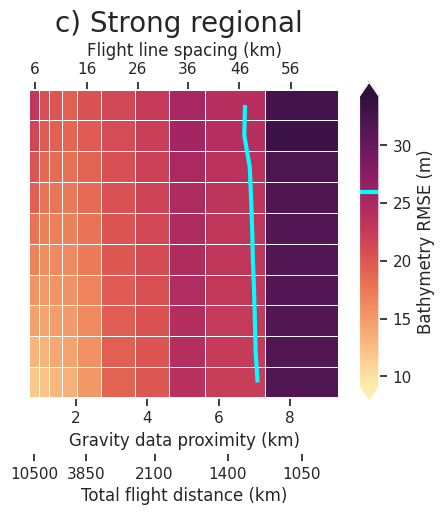

In [87]:
fig = synth_plotting.plot_2var_ensemble(
    sampled_params_df_strong_regional,
    figsize=figsize,
    x="grav_proximity",
    x_title="Gravity data proximity (km)",
    y="grav_noise_levels",
    y_title="Gravity noise (mGal)",
    background="final_inversion_rmse",
    background_title="Bathymetry RMSE (m)",
    background_robust=True,
    plot_contours=contours,
    contour_color="cyan",
    background_cpt_lims=cpt_lims,
    # colorbar=False,
    constrained_layout=False,
)
plt.gcf().text(0.5, 1.01, "c) Strong regional", fontsize=20, va="bottom", ha="center")
ax = fig.get_axes()[0]

# add second x axis with flight line spacing

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
x_tick_vals = df.grav_proximity.unique()
x_tick_labels = df.grav_line_spacing.unique()
x_tick_labels = [int(x) for x in x_tick_labels]
ax2.set_xticks(x_tick_vals)
ax2.set_xticklabels(x_tick_labels)
ax2.grid(False)
ax2.set_xlabel("Flight line spacing (km)")

# add second x axis with flight line spacing
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# x_tick_vals = sampled_params_df_strong_regional.grav_proximity.unique()
# x_tick_labels = sampled_params_df_strong_regional.grav_line_spacing.unique()
# inds_to_remove = [-2, -4]
# x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
# x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
# x_tick_labels = [round(x) for x in x_tick_labels]
# ax2.set_xticks(x_tick_vals)
# ax2.set_xticklabels(x_tick_labels)
# ax2.grid(False)
# ax2.set_xlabel("Flight line spacing (km)")

# add third x axis for flight distance
ax3 = ax.twiny()
ax3.set_xlim(ax.get_xlim())
x_tick_vals = sampled_params_df_strong_regional.grav_proximity.unique()
x_tick_labels = sampled_params_df_strong_regional.flight_kms.unique()
inds_to_remove = [-2, -3, -4, -6, -8]
x_tick_vals = np.delete(x_tick_vals, inds_to_remove)
x_tick_labels = np.delete(x_tick_labels, inds_to_remove)
x_tick_labels = [round(x) for x in x_tick_labels]
ax3.set_xticks(x_tick_vals)
ax3.set_xticklabels(x_tick_labels)
ax3.grid(False)
ax3.set_xlabel("Total flight distance (km)")
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
ax3.spines["bottom"].set_position(("outward", 40))

ax.yaxis.set_visible(False)

fig.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_2var.png",
    bbox_inches="tight",
    dpi=300,
)

In [88]:
# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_strong_regional,
#     figsize=figsize,
#     x="flight_kms",
#     x_title="Flight distance (km)",
#     y="grav_noise_levels",
#     y_title="Gravity noise (mGal)",
#     background="final_inversion_rmse",
#     background_title="Bathymetry RMSE (m)",
#     background_robust=True,
#     plot_contours=contours,
#     contour_color="cyan",
#     background_cpt_lims=cpt_lims,
#     # colorbar=False,
#     constrained_layout=False,
# )
# plt.gcf().text(0.5, .92, "c) Strong regional", fontsize=20, va="bottom", ha="center")

# ax = fig.get_axes()[0]

# x = "flight_kms"
# x2 = "grav_proximity"

# df = sampled_params_df_strong_regional[[x2, x]].drop_duplicates()

# a,b = df[x].min(), df[x].max()

# df = pd.concat(
#     [df, pd.DataFrame({x: ax.get_xticks()})]
# ).drop_duplicates(subset=[x])

# df = df[df[x].between(a, b)]

# df = synthetic.scipy_interp1d(
#     df,
#     to_interp=x2,
#     interp_on=x,
#     method="cubic",
# )
# df = df[df[x].isin(ax.get_xticks())].sort_values(x2)

# # add second x axis for line spacing
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())

# ax2.set_xticks(df[x])
# ax2.set_xticklabels([round(i,1) for i in df[x2]])
# ax2.grid(False)
# ax2.set_xlabel("Median proximity (km)")
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))

# # specify y ticks
# yvals = list(sampled_params_df_strong_regional.grav_noise_levels.unique())[::2]
# yvals.append(sampled_params_df_strong_regional.grav_noise_levels.unique()[-1])
# ax.set_yticks(yvals)
# ax.set_yticklabels([round(x, 1) for x in yvals])
# ax.tick_params(
#     axis="both",
#     which="both",
#     length=5,
#     bottom=True,
#     left=True,
# )
# plt.minorticks_off()

# ax.yaxis.set_visible(False)

# fig.savefig(
#     "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_2var.png",
#     bbox_inches="tight",
#     dpi=300,
# )

In [ ]:
# ax2 = ax.twiny()
# ax2.set_xticks([vals[0], vals[4], vals[6], vals[8], vals[9]])

# vals = [int(x) for x in sampled_params_df_low_regional.grav_line_spacing.unique()]
# ax2.set_xticklabels([vals[0], vals[4], vals[6], vals[8], vals[9]])
# ax2.xaxis.set_ticks_position("bottom")
# ax2.xaxis.set_label_position("bottom")
# ax2.spines["bottom"].set_position(("outward", 40))
# ax2.set_xlim(ax.get_xlim())
# ax2.grid(False)
# ax2.set_xlabel("Line spacing (km)")

# fig.savefig("../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_2var.png", bbox_inches="tight")
# fig

In [ ]:
# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_strong_regional,
#     figsize = (6,4),
#     x="grav_line_spacing",
#     y="grav_noise_levels",
#     x_title="Line spacing (km)",
#     y_title="Gravity noise (mGal)",

#     background="topo_improvement_mae",
#     background_title="Topo improvement (m)",

#     background_robust=True,
#     background_cmap="cmo.matter_r",
#     plot_contours=[0],
#     contour_color="cyan",
# )
# bbox = dict(facecolor='lightgray', boxstyle="round")
# plt.gcf().text(0.3, -.05, "many lines", fontsize=12, va="center", ha="right", bbox=bbox)
# plt.gcf().text(0.6, -.05, "few lines", fontsize=12, va="center", ha="left", bbox=bbox)

# plt.savefig('../paper/figures/ensemble_3_strong_regional_2var.png')

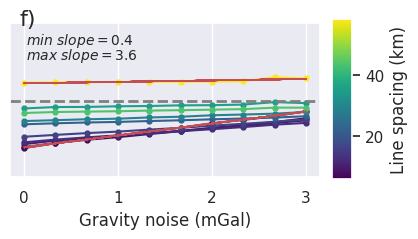

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_strong_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x="grav_noise_levels",
    x_label="Gravity noise (mGal)",
    # y="inversion_mae",
    # y_label="Bathymetry MAE (m)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_line_spacing",
    cbar_label="Line spacing (km)",
    # groupby_col="flight_kms_per_10000sq_km",
    # cbar_label="Flight km per 10000 $km^2$",
    trend_line=True,
    horizontal_line=contours,
    # horizontal_line_label="Starting MAE",
    # horizontal_line_label="Starting RMSE",
    # horizontal_line_label_loc="lower right",
    y_lims=line_plot_ylims,
    # slope_mean=True,
    slope_min_max=True,
    slope_decimals=1,
)
plt.gcf().text(0.15, 0.95, "f)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]
ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_bathy_error_vs_grav_noise.png",
    bbox_inches="tight",
    dpi=300,
)

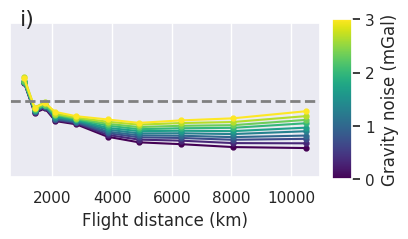

In [ ]:
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_strong_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x="flight_kms",
    x_label="Flight distance (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
)
plt.gcf().text(0.15, 0.95, "i)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_bathy_error_vs_grav_spacing.png",
    bbox_inches="tight",
    dpi=300,
)

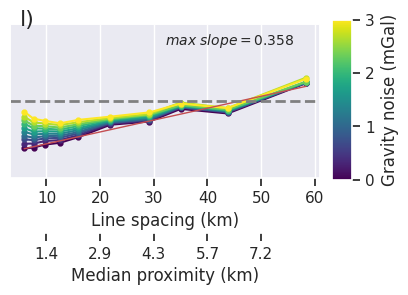

In [ ]:
x = "grav_line_spacing"
x2 = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_strong_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Line spacing (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    # horizontal_line_label="Starting RMSE",
    # horizontal_line_label_loc="upper right",
    y_lims=line_plot_ylims,
    # logx=True,
    # colorbar=False,
    trend_line=True,
    slope_max=True,
    trend_line_text_loc=(0.5, 0.95),
)
plt.gcf().text(0.15, 0.95, "l)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

df = sampled_params_df_strong_regional[[x2, x]].drop_duplicates()

a, b = df[x].min(), df[x].max()

df = pd.concat([df, pd.DataFrame({x: ax.get_xticks()})]).drop_duplicates(subset=[x])

df = df[df[x].between(a, b)]

df = synthetic.scipy_interp1d(
    df,
    to_interp=x2,
    interp_on=x,
    method="cubic",
)
df = df[df[x].isin(ax.get_xticks())].sort_values(x2)

# add second x axis for line spacing
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ax2.set_xticks(df[x])
ax2.set_xticklabels([round(i, 1) for i in df[x2]])
ax2.grid(False)
ax2.set_xlabel("Median proximity (km)")
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("outward", 40))

ax.yaxis.set_visible(False)

# plt.savefig(
#     "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_bathy_error_vs_grav_spacing_2.png",
#     bbox_inches="tight",
#     dpi=300,
# )

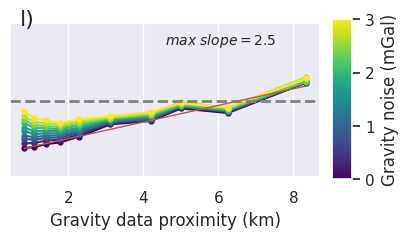

In [ ]:
x = "grav_proximity"
fig = synth_plotting.plot_ensemble_as_lines(
    sampled_params_df_strong_regional,
    figsize=(figsize[0], figsize[1] / 2),
    x=x,
    x_label="Gravity data proximity (km)",
    y="final_inversion_rmse",
    y_label="Bathymetry RMSE (m)",
    groupby_col="grav_noise_levels",
    cbar_label="Gravity noise (mGal)",
    horizontal_line=contours,
    y_lims=line_plot_ylims,
    # logx=True,
    # colorbar=False,
    trend_line=True,
    slope_max=True,
    trend_line_text_loc=(0.5, 0.95),
    slope_decimals=1,
)
plt.gcf().text(0.15, 0.95, "l)", fontsize=16, va="top", ha="left")

ax = fig.get_axes()[0]

ax.yaxis.set_visible(False)

plt.savefig(
    "../paper/figures/Ross_Sea_noise_vs_spacing_strong_regional_bathy_error_vs_grav_spacing_2.png",
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
# # subplots showing inverted bathymetry's
# grids = []
# cbar_labels = []
# row_titles = []
# column_titles = []

# df = sampled_params_df_strong_regional
# # iterate over the ensemble starting with high noise, small line spacing
# # row per noise level and column per line spacing
# for i, row in df.sort_values(
#     by=["grav_noise_levels", "grav_line_spacing"], ascending=[False, True]
# ).iterrows():
#     inverted_bathymetry = xr.open_dataarray(row.inverted_bathymetry_fname)

#     dif = bathymetry - inverted_bathymetry

#     # reg = vd.pad_region(inversion_region, -3*spacing)
#     reg = inversion_region
#     inverted_bathymetry = inverted_bathymetry.sel(
#         easting=slice(reg[0], reg[1]),
#         northing=slice(reg[2], reg[3]),
#     )
#     dif = dif.sel(
#         easting=slice(reg[0], reg[1]),
#         northing=slice(reg[2], reg[3]),
#     )
#     # add to lists
#     grids.append(inverted_bathymetry)
#     grids.append(dif)
#     cbar_labels.append(f"MAE: {round(row.inversion_mae,2)} m")
#     cbar_labels.append(" ")
#     if i % np.sqrt(len(df)) == 0:
#         column_titles.append(round(row.grav_line_spacing))
#         column_titles.append(" ")
#     if i < np.sqrt(len(df)):
#         row_titles.append(round(row.grav_noise_levels, 1))
#         # row_titles.append(" ")

# fig = maps.subplots(
#     grids,
#     dims=(np.sqrt(len(df)), 2 * np.sqrt(len(df))),
#     fig_height=8,
#     fig_title="Strong regional",
#     fig_x_axis_title="Flight line spacing (km)",
#     fig_y_axis_title="Gravity noise (mGal)",
#     fig_title_font="100p,Helvetica-Bold,black",
#     fig_axis_title_font="80p,Helvetica-Bold,black",
#     fig_title_y_offset="8c",
#     fig_x_axis_title_y_offset="2.5c",
#     fig_y_axis_title_x_offset="3c",
#     cbar_labels=cbar_labels,
#     cmaps=[x for xs in [["rain", "balance+h0"] for x in range(len(df))] for x in xs],
#     reverse_cpt=True,
#     # colorbar=False,
#     # hist=True,
#     # cpt_lims=polar_utils.get_combined_min_max(grids, robust=True),
#     cpt_limits=[
#         x
#         for xs in [
#             [
#                 polar_utils.get_combined_min_max(grids[::2], robust=True),
#                 polar_utils.get_combined_min_max(grids[1::2], robust=True),
#             ]
#             for x in range(len(df))
#         ]
#         for x in xs
#     ],
#     cbar_font="45p,Helvetica,black",
#     row_titles=row_titles,
#     column_titles=column_titles,
#     row_titles_font="70p,Helvetica,black",
#     column_titles_font="70p,Helvetica,black",
# )

# fig.savefig(
#     "../paper/figures/Ross_Sea_ensemble_strong_regional_inverted_bathymetry_and_errors.png",
#     dpi=500,
# )
# fig.show()

In [ ]:
# for i, row in sampled_params_df_strong_regional.iterrows():
#     grav_df = pd.read_csv(row.grav_df_fname)
#     # true_reg = grav_df.gravity_anomaly - grav_df.bathymetry_grav
#     true_reg = grav_df.basement_grav

#     sampled_params_df_strong_regional.loc[i, "misfit_stdev"] = grav_df.misfit.std()
#     sampled_params_df_strong_regional.loc[i, "grav_anom_stdev"] = grav_df.gravity_anomaly.std()
#     sampled_params_df_strong_regional.loc[i, "true_regional_stdev"] = true_reg.std()
#     sampled_params_df_strong_regional.loc[i, "estimated_regional_stdev"] = grav_df.reg.std()

# sampled_params_df_strong_regional.head()

In [97]:
# sampled_params_df_strong_regional["true_regional_stdev"]

In [ ]:
# anoms = [
#     "misfit_stdev",
#     "grav_anom_stdev",
#     "estimated_regional_stdev",
# ]
# reg_stats = [
#     "true_regional_stdev",
# ]
# df = sampled_params_df_strong_regional[anoms+reg_stats].corr()[reg_stats].drop(reg_stats)
# sns.heatmap(
#     df,
#     # robust=True,
#     annot=True,
#     vmin=0.5,
#     vmax=0.98,
# )
# plt.title("Grav spacings vs noise; Strong regional", fontsize=15)
# df

In [ ]:
# anoms = [
#     "misfit_stdev",

#     "grav_anom_stdev",

#     "estimated_regional_stdev",
# ]
# reg_stats = [
#     "true_regional_stdev",
# ]
# df = sampled_params_df_strong_regional[anoms+reg_stats].corr()[reg_stats].drop(reg_stats)
# sns.heatmap(
#     df,
#     # robust=True,
#     annot=True,
#     vmin=0.5,
#     vmax=0.98,
# )
# plt.title("Grav spacings vs noise; Strong regional", fontsize=15)
# df

In [ ]:
# sampled_params_df_strong_regional["regional_strength_estimation"]=sampled_params_df_strong_regional.true_regional_stdev-sampled_params_df_strong_regional.grav_anom_stdev

# fig = synth_plotting.plot_2var_ensemble(
#     sampled_params_df_strong_regional,
#     figsize=figsize,
#     # x="grav_line_spacing",
#     # x_title="Line spacing (km)",
#     x="flight_kms_per_10000sq_km",
#     x_title="Flight km per 10000 $km^2$",
#     y="grav_noise_levels",
#     y_title="Gravity noise (mGal)",
#     background="regional_strength_estimation",
#     background_title="regional_strength_estimation",
#     background_robust=True,
#     background_cmap="cmo.balance",
#     background_cpt_lims=[-1,1],
#     plot_contours=contours,
#     contour_color="cyan",
#     # background_cpt_lims=cpt_lims,
#     # flipx=True,
# )

# 5 m of inversion improvement

In [ ]:
# width = (inversion_region[1] - inversion_region[0]) / 1e3
# height = (inversion_region[3] - inversion_region[2]) / 1e3
# width, height

In [ ]:
# inversion_area

In [ ]:
# line_spacing = 85
# width / line_spacing, height / line_spacing

In [ ]:
# grav_survey_85k = synthetic.airborne_survey(
#     along_line_spacing=1e3,
#     grav_observation_height=1e3,
#     ns_line_spacing=85e3,
#     ew_line_spacing=85e3,
#     region=inversion_region,
#     plot=True,
# )

In [ ]:
# 85 - 35

In [ ]:
# grav_survey_50k = synthetic.airborne_survey(
#     along_line_spacing=1e3,
#     grav_observation_height=1e3,
#     ns_line_spacing=50e3,
#     ew_line_spacing=50e3,
#     region=inversion_region,
#     plot=True,
# )

In [ ]:
# # semi-regularly spaced
# constraints_80k = synthetic.constraint_layout_number(
#     spacing=(80e3, 80e3), region=inversion_region, plot=True
# )

In [ ]:
# # semi-regularly spaced
# constraints_73k = synthetic.constraint_layout_number(
#     spacing=(73e3, 73e3), region=inversion_region, plot=True
# )

In [ ]:
# len(grav_survey_85k)

In [ ]:
# len(grav_survey_50k)

In [ ]:
# fig = maps.basemap(
#     region=inversion_region,
#     # frame=True,
#     fig_height=10,
#     scalebar=True,
#     scale_position="JBC+o0c/.1c",
# )

# fig.plot(
#     grav_survey_85k[["easting", "northing"]],
#     style="p.1c",
#     fill="purple",
#     label=f"85 km spacing; {len(grav_survey_85k)} line-kms",
# )
# fig.plot(
#     grav_survey_50k[["easting", "northing"]],
#     style="p.1c",
#     fill="orange",
#     label=f"50 km spacing; {len(grav_survey_50k)} line-kms",
# )

# fig.legend()
# fig.show()

In [ ]:
# fig = maps.basemap(
#     region=inversion_region,
#     # frame=True,
#     fig_height=10,
#     scalebar=True,
#     scale_position="JBC+o0c/.1c",
# )

# fig.plot(
#     constraints_80k[["easting", "northing"]],
#     style="t.3c",
#     fill="purple",
#     pen="1p,black",
#     label=f"80 km spacing; {len(constraints_80k)} points",
# )
# fig.plot(
#     constraints_73k[["easting", "northing"]],
#     style="t.3c",
#     fill="orange",
#     pen="1p,black",
#     label=f"73 km spacing; {len(constraints_73k)} points",
# )

# fig.legend()
# fig.show()